# Kaz Lab Python Plotting Workshop
***
2018.05.25
Updated 2018.07.24

## Objectives

By the end of this workshop, you will be able to:

- Create, launch, and run commands in an interactive Python ([IPython](https://ipython.readthedocs.io/en/stable/index.html)) notebook
- Load single timepoint or time series data from a plate reader using `pandas`
- Convert plate reader data into the "tidy" format, and join your raw data to metadata in a plate map
- Make exploratory plots which compare different variables and subsets of your data

### Un-objectives

This workshop will **not** teach you Python in general; our goal is to learn just enough Python that you can make useful plots. Likewise we are going to use several giant and complicated libraries—but only very small parts of them.

I will focus on quickly generating plots for exploratory data analysis—I will not cover the numerous options for generating publication- (or even presentation-) quality plots.

## Getting started

### The Notebook and You

Let's first get acquainted with the notebook. This notebook is part of a project called [Jupyter](http://jupyter.org), which, in general, lets you write and run code "interactively"---that is, you write a little snippet of code, then run it and see the results. You can keep repeating this, and your variables live on across multiple snippets. 

Behind the scenes, your notebook is sending these commands to a program—called a "kernel"—which executes the commands, keeps track of your variables, and sends you the results. (In this case, the kernel is [IPython](https://ipython.readthedocs.io/en/stable/index.html), but [you can use many other programming languages as well](https://github.com/jupyter/jupyter/wiki/Jupyter-kernels)!) **This means your variables stick around as long as the kernel stays alive.** If you close this browser window and return to it later, your variables will still be there. If you restart your computer, the notebook server, or the kernel, you will have to re-run the cells in your notebook to get your variables back.

Try running the code in the cell below: click on the box, then press `Shift + Enter`

In [1]:
1 + 1

2

The output appears below the input cell. This highlights another feature of the notebook—**it is a record of what commands you ran to analyze your data**. In this way, it's a lot like a lab notebook for analysis. This is very important for a few reasons:

1. **It makes your analysis reproducible**; given your notebook and your data, someone else could repeat the exact same analysis to verify your results.

2. **It makes it analysis verifiable**; since there is a record of the exact commands you ran, someone else can read your code to see if you have made a mistake, an invalid assumption, etc. If you are copying and pasting data from Excel into Prism, there is no way for someone else to check that every range was copied correctly. If you make a mistake, it can be silently propagated through your thinking and analysis, and your conclusions could be completely wrong! 

The very basics of Python:

- Define a variable `x` and assign it a value like this:
    
    ```python
    x = 10
    ```
    
    Note that a single equals sign (`=`) is **assignment**—it _sets_ `x` equal to `10`. To test if 
    `x` _is already equal_ to `10`, use two equals signs (`==`):
    
    ```ipython
     In[1]: x == 10
    Out[1]: True
    ```
    
    
- Text surrounded by quotes (`'` or `"`) is called a string:

    ```python
    y = 'Hello'
    ```
        
- You can call functions by writing the name of the function, followed by parenthesis, with any parameters (also called arguments) inside the parentheses—like this:

    ```python
    print("Hello world")
    ```
    
- Anything that follows a `#` sign is a comment:

    ```python
    print("Hello world") # stuff back here doesn't do anything
    ```

A few more tips about the Notebook:

- To get help with an object or function, type it's name followed by `?`. Try it in the box below:

In [2]:
int?

- IPython can auto-complete many commands if you type a few characters and press `tab`. **Exercise:** Run the cell below, then see if you can figure out how to capitalize the text in `s` so it reads `Hello world` (Hint: you can call functions like this `s.upper()`):

In [3]:
s = 'hello world'
s.upper()

'HELLO WORLD'

In [4]:
# finish this command so it prints 'Hello world'
s.capitalize()

'Hello world'

- Use the white buttons near the top to add, cut/paste, and move cells. Click the `+` button to add a new cell
- If you start running a command that's taking too long, use the `Kernel` menu to `Interrupt`. If things get really messed up, you can `Restart` the kernel. Once you've done that, you may want to use the `Cell` menu to run all the cells above your current position, in order to revive all your variables.
- You can export your notebook to several different formats (like HTML or PDF), if you want to share your analysis with someone who doesn't have Jupyter/IPython.

### Tools of the Trade

Enough of that, let's get started. First, we will **`import`** a bunch of libraries so we can work with them. 

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import re

import plates

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context("notebook", font_scale=1.2)
pd.set_option("display.max_rows",10)

I copy and paste almost this exact statement at the top of each of my notebooks; when I need other things, I'll add stuff, but this imports most of the important libraries that I use regularly. It's important having a big-picture conceptual understanding of what each library does, since they build on each other—sometimes a function that doesn't exist in a "higher-level" library can be found in a "lower-level" library.

- [NumPy](https://docs.scipy.org/doc/numpy/) (`np`): provides an N-dimensional array (`ndarray`)—much like a matrix in MATLAB. Your data is a matrix of numbers, and NumPy provides that matrix
- [Pandas](http://pandas.pydata.org/pandas-docs/stable/) (`pd`): provides objects Series, DataFrame, and Panel that wrap NumPy arrays and label their contents. For instance, rather than having to remember that column `7` of your matrix represents the strain, you can label that column as such. This may seem small, but it makes a huge difference. 
- [Matplotlib](https://matplotlib.org/api/pyplot_summary.html) (`plt`): low-level plotting library, originally based on the plotting functions in MATLAB. 
- [Seaborn](https://seaborn.pydata.org/api.html) (`sns`): high-level plotting library for making complex visualizations—most importantly "grids" of plots (a.k.a. facets, lattice plots, trellis plots, or "small multiples"), and statistical plots.


- `plates` is a library I wrote for describing plate maps and joining them to your data. I think it makes the analysis more straightforward, but you could do all of this without it

### Loading and "Wrangling" data

In this workshop, we'll focus on data from a microplate reader, like the Tecan. Other data will be slightly different, but the overall process will be the same. Furthermore, we'll "wrangle" our data into a common format that will let us approach many data sets in the same manner.

The basic approach:

- Import raw data using Pandas
- Convert raw data into "tidy" format
- Join raw data to metadata (plate map)


We'll work through several "case studies" based on experiments done in the lab. These were chosen to emphasize different types of data and techniques for analyzing/plotting with them—not because of the significance of the experiments or the data.

## Case 1: Oxyrase

Goal: The goal of this experiment (CG016e) was to determine if a difference in growth rate (manifested by a difference in OD600 after ~16 hours of incubation) could be measured in non-shaking cultures of _Pseudomonas_ growing in closed Eppendorf tubes. 

Method: I inoculated exponential-phase _Pseudomonas_ into aliquots of LB media supplemented with various combinations of nitrate, oxyrase, and tungstate. For each media condition, I did 3 biological replicates. The next day, I vortexed each cultures and divided that culture into 3 wells of a 96-well plate, then measured the OD with the Tecan. 

Data: single, endpoint measurement of a 96-well plate

### Case 1: Loading & Wrangling
Let's start by importing the data from the Excel file produced by the Tecan

In [6]:
data = pd.read_excel('./data/2018-03-30_CG016e_doctored.xlsx', # path to the Excel file
                     sheet_name=0, # index of the sheet to read; you could also pass a name like 'Sheet1'
                     header=26, # which row (zero-indexed) to start reading from; skips all the extra metadata
                                # junk that Tecan inserts
                     skipfooter=4, # how many rows to skip at the bottom of the file (Tecan puts some stuff 
                                   # there too)
                     index_col=0)  # which column to use to "index" the data
data

1       2       3       4       5       6       7       8       9   \
<>                                                                           
A   0.1780  0.1856  0.1988  0.1964  0.2001  0.1983  0.1954  0.2016  0.2095   
B   0.1453  0.1533  0.1515  0.1490  0.1476  0.1709  0.1827  0.1891  0.1923   
C   0.4125  0.4335  0.4390  0.4224  0.4317  0.4376  0.4239  0.4355  0.4404   
D   0.4287  0.4218  0.4202  0.4582  0.4292  0.4213  0.3880  0.4137  0.4117   
E   0.1991  0.1988  0.1931  0.2022  0.2148  0.2117  0.1961  0.2015  0.1981   
F   0.2055  0.1804  0.1863  0.1783  0.1815  0.1782  0.1953  0.1900  0.1905   
G   0.2276  0.2331  0.2229  0.2201  0.2237  0.2211  0.2161  0.2155  0.2188   
H   0.2778  0.2484  0.2564  0.2462  0.2375  0.2376  0.2472  0.2472  0.2475   

        10      11      12  
<>                          
A   0.0912  0.0916  0.0986  
B   0.1469  0.1490  0.1507  
C   0.0898  0.0939  0.0905  
D   0.1150  0.1308  0.1176  
E   0.0966  0.0962  0.0985  
F   0.1363  0.1375  0.1341  
G   0.0926  0.0937  0.0942  
H   0.1522  0.1521  0.1490

Neat, it looks like a plate. Let's discuss the data structures we're using and introduce some terminology:

- This dataset is now in a form called a [Pandas **DataFrame**](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), which is a 2D table
- Notice that the dataset is labeled—each row has a label, and each column has a label. The list of labels for the rows (`A`, `B`, `C`, etc.) is called the **`index`**. The labels for the columns is just called **`columns`**.
- You can pull out a single column from the DataFrame like this, which produces a 1D table called a [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html):

In [7]:
data[1]

<>
A    0.1780
B    0.1453
C    0.4125
D    0.4287
E    0.1991
F    0.2055
G    0.2276
H    0.2778
Name: 1, dtype: float64

Let's talk about how the data is formatted. Each row and column in the DataFrame corresponds to a row and column in our physical microtiter plate; initially this seems intuitive, but it will be difficult to work with the data in this form for a few reasons:

- **There's no metadata**: we can't tell from this dataset what cells correspond to what conditions, which cells are replicates of one another, and so on.
- Even if I told you that `A1:A12` corresponded to the `LB alone` condition, with `A1:A3`, `A4:A6`, and `A7:A9` each three technical replicates of three biological replicates, it would be tricky to pull those nine values and group them appropriately for plotting or analysis. **The structure of our table does not correspond to the structure of our data**, even if it mimics the physical layout of our experiment. 
- It would be even more difficult if I told you that rows `B`, `D`, `F`, and `H` had oxyrase, and I wanted you to compare them to the rows which did not; comparing these rows would require a different set of strategies than comparing the replicates in the same row. **Different comparisons require very different code**.

To address these problems, we're going to convert our data into a ["Tidy" format](http://vita.had.co.nz/papers/tidy-data.pdf), which will make it easier to process, visualize, and analyze. 

In [8]:
# collect data into "tidy" format, with one row per observation, one column for each variable (well, time, OD600)
data.columns = data.columns.rename('column')
data.index = data.index.rename('row')
data = data.reset_index()
data = data.melt(id_vars=['row'],var_name='column',value_name='OD600')
data['well'] = data['row'] + data['column'].map(str)
data['row'] = data['row'].map(plates.letters2row)
data['column'] = data['column'] - 1
data

row column   OD600 well
0     0      0  0.1780   A1
1     1      0  0.1453   B1
2     2      0  0.4125   C1
3     3      0  0.4287   D1
4     4      0  0.1991   E1
..  ...    ...     ...  ...
91    3     11  0.1176  D12
92    4     11  0.0985  E12
93    5     11  0.1341  F12
94    6     11  0.0942  G12
95    7     11  0.1490  H12

[96 rows x 4 columns]

(Note: For the purposes of this tutorial, I've told Pandas to [only show a few rows of each dataset](https://pandas.pydata.org/pandas-docs/stable/options.html#frequently-used-options) to keep things clean. Here are some functions to show more and to show all of a data set; if the output gets long enough, the notebook will collapse cell, and you can scroll separately inside it.)

In [9]:
def display_more(df):
    with pd.option_context("display.max_rows",40,"display.max_columns", 40):
        display(df)

def display_all(df):
    with pd.option_context("display.max_rows",None,"display.max_columns", None):
        display(df)

At first, this doesn't seem like an improvement. We'll really see the gains when we attach metadata from our platemap to this raw data. Here's the full platemap:


| _     | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Media | Nitrate | Tungstate | Oxyrase |
|-------|---|---|---|---|---|---|---|---|---|----|----|----|-------|---------|-----------|---------|
| **A** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LB    | -       | -         | -       |
| **B** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLB   | -       | -         | +       |
| **C** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LBN   | +       | -         | -       |
| **D** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLBN  | +       | -         | +       |
| **E** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LBT   | -       | +         | -       |
| **F** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLBT  | -       | +         | +       |
| **G** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | LBNT  | +       | +         | -       |
| **H** | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | s  | s  | s  | OLBNT | +       | +         | +       |


Numbers within the table (1, 2, 3) refer to biological replicates, and (s) refers to the sterile wells. Each row is a different media condition, with various combinations of nitrate, tungstate, and oxyrase. 

In the next function, we'll build a table which has the same structure as our raw data---one row for every well---but we'll add columns corresponding to our other "metadata" variables: 

In [10]:
# build platemap with relevant metadata
platemap = plates.prog2spec({
  "A:A": {"condition":"LB",    "oxyrase": 0, "nitrate": 0,  "tungstate": 0},
  "B:B": {"condition":"OLB",   "oxyrase": 1, "nitrate": 0,  "tungstate": 0},
  "C:C": {"condition":"LBN",   "oxyrase": 0, "nitrate": 10, "tungstate": 0},
  "D:D": {"condition":"OLBN",  "oxyrase": 1, "nitrate": 10, "tungstate": 0},
  "E:E": {"condition":"LBT",   "oxyrase": 0, "nitrate": 0,  "tungstate": 10},
  "F:F": {"condition":"OLBT",  "oxyrase": 1, "nitrate": 0,  "tungstate": 10},
  "G:G": {"condition":"LBNT",  "oxyrase": 0, "nitrate": 10, "tungstate": 10},
  "H:H": {"condition":"OLBNT", "oxyrase": 1, "nitrate": 10, "tungstate": 10},
  "A1:H3": {"sample":"1"},
  "A4:H6": {"sample":"2"},      
  "A7:H9": {"sample":"3"}, 
  "A10:H12": {"sample":"sterile", "sterility":'sterile' }, 
}, include_row_column=False)
platemap

condition  oxyrase  nitrate  tungstate   sample sterility
A1         LB      0.0      0.0        0.0        1       NaN
A2         LB      0.0      0.0        0.0        1       NaN
A3         LB      0.0      0.0        0.0        1       NaN
A4         LB      0.0      0.0        0.0        2       NaN
A5         LB      0.0      0.0        0.0        2       NaN
..        ...      ...      ...        ...      ...       ...
H8      OLBNT      1.0     10.0       10.0        3       NaN
H9      OLBNT      1.0     10.0       10.0        3       NaN
H10     OLBNT      1.0     10.0       10.0  sterile   sterile
H11     OLBNT      1.0     10.0       10.0  sterile   sterile
H12     OLBNT      1.0     10.0       10.0  sterile   sterile

[96 rows x 6 columns]

All this confusing-looking statement does is turn a list of statements about our plate into a DataFrame which organizes those statements into a table---one row per well, one column for each type of metadata. 

Finally, we'll merge our platemap and our raw data into a single table. The call to `pd.merge` tells Pandas to do an [inner join](https://en.wikipedia.org/wiki/Join_(SQL)#Inner_join) (give rows that show up in both the `data` and `platemap` DataFrames), and to use the column `well` from `data`, and the `index` from the `platemap` to match rows between the two DataFrames

In [11]:
# join platemap to observations, 
data = pd.merge(data,platemap, how='inner', left_on='well', right_index=True)
data = data.fillna({'sterility': 'non-sterile'})

data

row column   OD600 well condition  oxyrase  nitrate  tungstate   sample  \
0     0      0  0.1780   A1        LB      0.0      0.0        0.0        1   
1     1      0  0.1453   B1       OLB      1.0      0.0        0.0        1   
2     2      0  0.4125   C1       LBN      0.0     10.0        0.0        1   
3     3      0  0.4287   D1      OLBN      1.0     10.0        0.0        1   
4     4      0  0.1991   E1       LBT      0.0      0.0       10.0        1   
..  ...    ...     ...  ...       ...      ...      ...        ...      ...   
91    3     11  0.1176  D12      OLBN      1.0     10.0        0.0  sterile   
92    4     11  0.0985  E12       LBT      0.0      0.0       10.0  sterile   
93    5     11  0.1341  F12      OLBT      1.0      0.0       10.0  sterile   
94    6     11  0.0942  G12      LBNT      0.0     10.0       10.0  sterile   
95    7     11  0.1490  H12     OLBNT      1.0     10.0       10.0  sterile   

      sterility  
0   non-sterile  
1   non-sterile  
2   non-sterile  
3   non-sterile  
4   non-sterile  
..          ...  
91      sterile  
92      sterile  
93      sterile  
94      sterile  
95      sterile  

[96 rows x 10 columns]

Now we have our complete dataset in a "Tidy" format. **"Tidy" data** has the following form:

- Each **variable** is in a column
- Each **observation** is in a row. 

"A dataset is a collection of **values**, usually either numbers (if quantitative) or strings (if qualitative). Values are organised in two ways. Every value belongs to a variable and an observation. A **variable** contains all values that measure the same underlying attribute (like height, temperature, duration) across units. An **observation** contains all values measured on the same unit (like a person, or a day, or a race) across attributes" ([Wickam 2014](http://vita.had.co.nz/papers/tidy-data.pdf)).

![](http://r4ds.had.co.nz/images/tidy-1.png)

It's tricky to precisely define "observations" and "variables" in general, but it's usually easy to tell for a given dataset. In this example, our "observations" correspond to single wells, so each row contains all the data about a given well. Our variables are `OD600`, `well`, `oxyrase`, `nitrate`, `tungstate`, `sample`, and `sterility`. Notice that each is the name of a column in our table. Somewhat confusingly, we also have variables called `row` and `column`---these correspond to the row/column of each well within the original, physical microplate (Don't get confused between the rows/columns of wells in the physical plate and the rows/columns in our `DataFrame`!). We also defined a convenience column `condition`, which summarizes the information in the `oxyrase`, `nitrate`, and `tungstate` columns. 



### Case 1: Plotting

For single timepoint data, I always like to start by looking at the data for the whole plate as a heatmap to see if any patterns jump out:

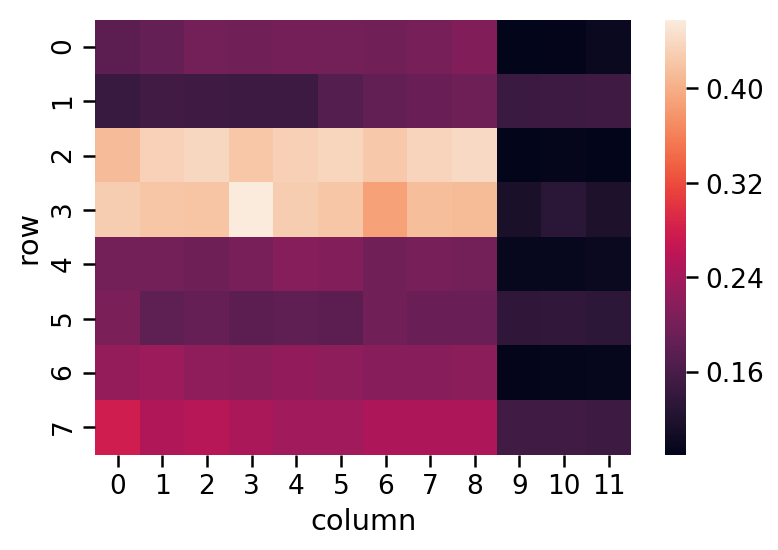

In [12]:
g = sns.heatmap(data=data.pivot('row','column','OD600'))

> (The `data.pivot` statement brings our data back into a form that looks a lot like the one we started with. It may seem silly to go through all this trouble to convert data into a tidy format—only to convert it straight back! But this demonstrates an important point—there are lots of functions built in to Pandas (and other libraries) to take tidy data and convert it into other formats.)

In [13]:
data.pivot('row','column','OD600')

column      0       1       2       3       4       5       6       7   \
row                                                                      
0       0.1780  0.1856  0.1988  0.1964  0.2001  0.1983  0.1954  0.2016   
1       0.1453  0.1533  0.1515  0.1490  0.1476  0.1709  0.1827  0.1891   
2       0.4125  0.4335  0.4390  0.4224  0.4317  0.4376  0.4239  0.4355   
3       0.4287  0.4218  0.4202  0.4582  0.4292  0.4213  0.3880  0.4137   
4       0.1991  0.1988  0.1931  0.2022  0.2148  0.2117  0.1961  0.2015   
5       0.2055  0.1804  0.1863  0.1783  0.1815  0.1782  0.1953  0.1900   
6       0.2276  0.2331  0.2229  0.2201  0.2237  0.2211  0.2161  0.2155   
7       0.2778  0.2484  0.2564  0.2462  0.2375  0.2376  0.2472  0.2472   

column      8       9       10      11  
row                                     
0       0.2095  0.0912  0.0916  0.0986  
1       0.1923  0.1469  0.1490  0.1507  
2       0.4404  0.0898  0.0939  0.0905  
3       0.4117  0.1150  0.1308  0.1176  
4       0.1981  0.0966  0.0962  0.0985  
5       0.1905  0.1363  0.1375  0.1341  
6       0.2188  0.0926  0.0937  0.0942  
7       0.2475  0.1522  0.1521  0.1490

It looks like the columns on the right have a much lower OD than the ones on the left—this makes sense, because  they were the sterile wells. Let's plot the mean of the sterile wells against the non-sterile wells:

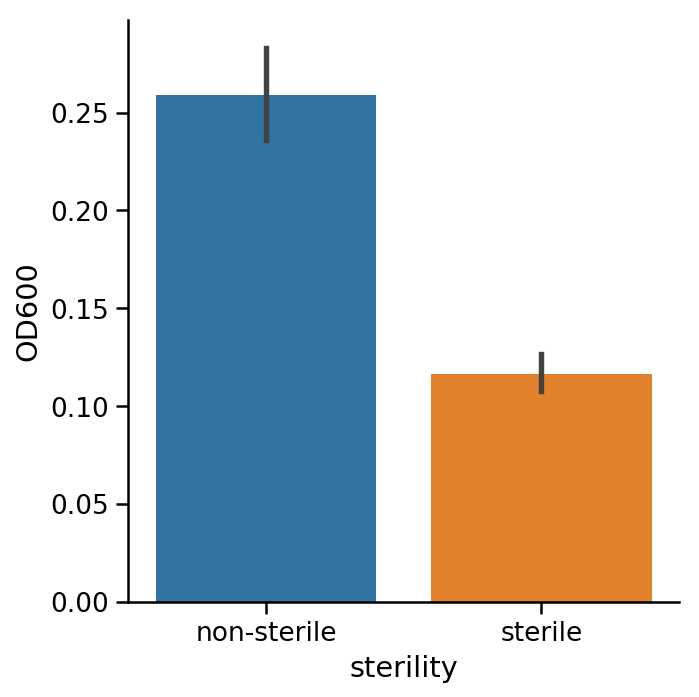

In [14]:
g = sns.catplot(data=data,x="sterility",y="OD600",kind="bar")

[`catplot`](https://seaborn.pydata.org/generated/seaborn.catplot.html) is an incredibly useful function provided by Seaborn, which will be your Swiss-Army knife for [working with categorical data](https://seaborn.pydata.org/tutorial/categorical.html) (hence the name `catplot`, for `cat`egorical plot). Every call to `catplot` looks like this: 
- first pass it your dataset
    
        g = sns.catplot(data=data,x="sterile",y="OD600",kind="bar")
                        ^^^^^^^^^
        
- then tell it how to map your variables onto elements of the plot:

        g = sns.catplot(data=data,x="sterile",y="OD600",kind="bar")
                                  ^^^^^^^^^^^ ^^^^^^^^^

- finally, tell it what `kind` of plot to draw

        g = sns.catplot(data=data,x="sterile",y="OD600",kind="bar")
                                                        ^^^^^^^^^^

You can draw a surprising variety of [`kind`s](https://seaborn.pydata.org/api.html#categorical-plots) of plots, just with this one function. (note: `catplot` used to be called `factorplot`, so if you see references to `factorplot`, you can use it exactly the same way as `catplot`)

Our bar plot collapses the entire distribution down to a mean and confidence interval. If we wanted to see the full range of values in the `'sterile'` and `'non-sterile'` groups, we could use a `box` plot:

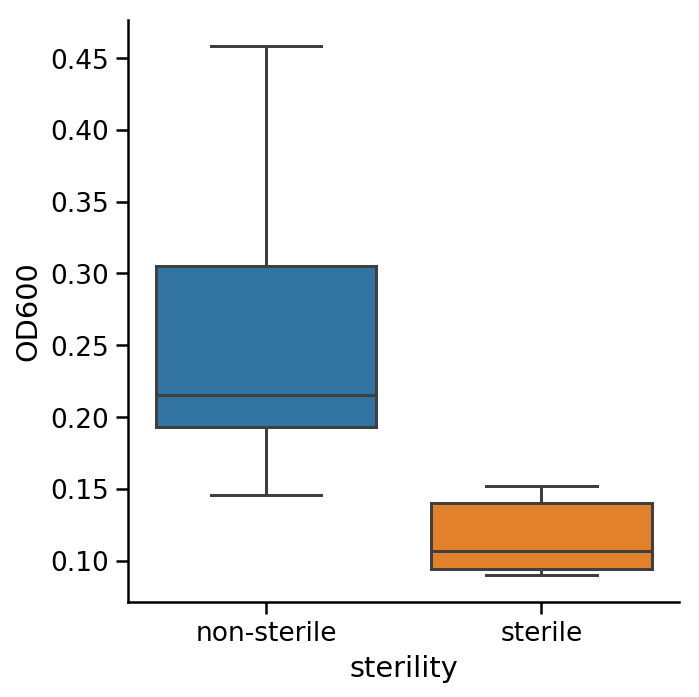

In [15]:
g = sns.catplot(data=data,x="sterility",y="OD600",kind="box")

**Exercise** Try it yourself: adapt this code to make a `swarm`plot and a `violin`plot:

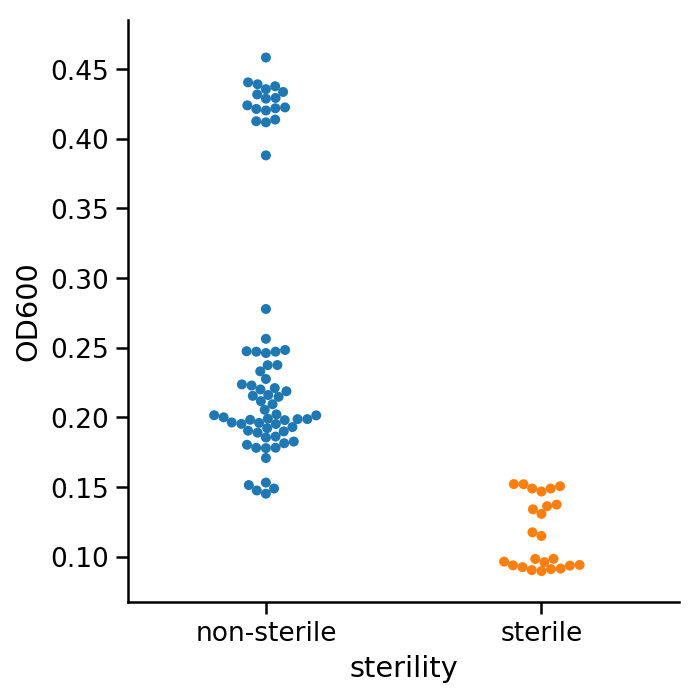

In [16]:
g = sns.catplot(data=data,x="sterility",y="OD600",kind="swarm")

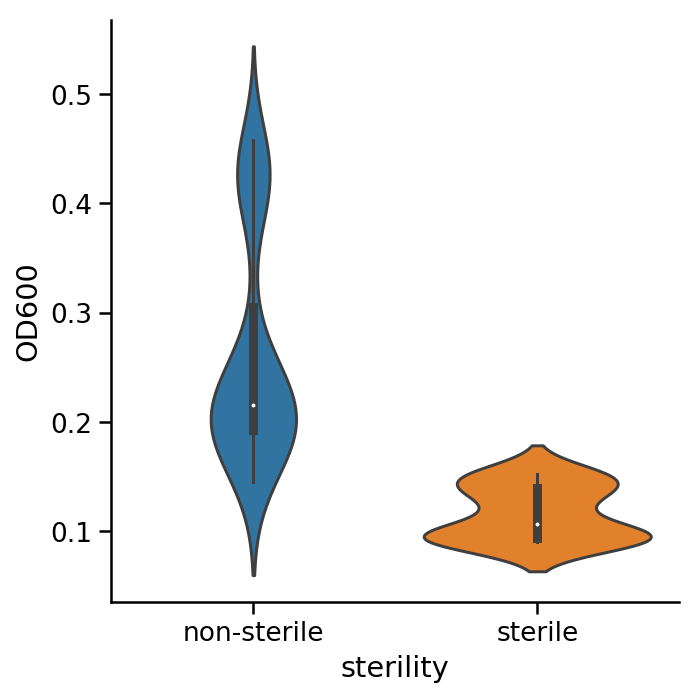

In [17]:
g = sns.catplot(data=data,x="sterility",y="OD600",kind="violin")

What are the advantages of these plots over the `bar` plot or the `box` plots?

***
Let's make a different comparison: are the oxyrase wells different from the non-oxyrase wells? 

**Exercise:** Generalize the code from above to make a `bar` plot with `oxyrase` concentration on the x-axis and `OD600` on the y-axis:

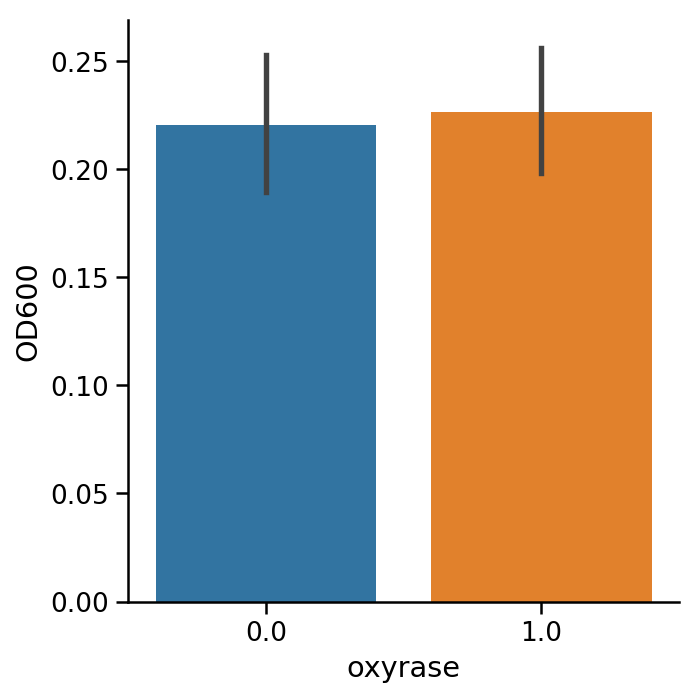

In [18]:
g = sns.catplot(data=data,x="oxyrase",y="OD600",kind="bar")

Looks like they're not different in general, but what about if we separate the sterile vs. non-sterile groups:

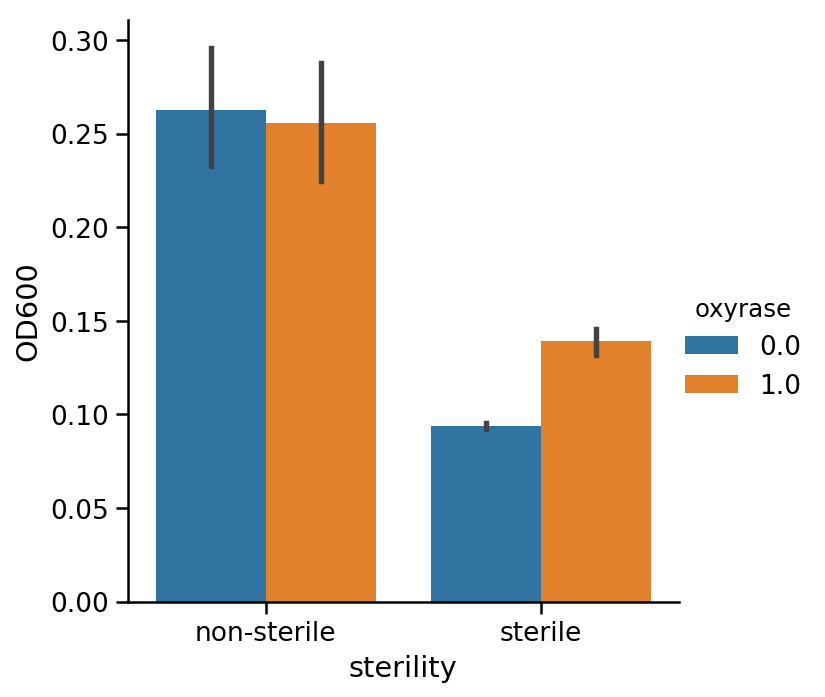

In [19]:
g = sns.catplot(data=data,x="sterility",y="OD600",hue="oxyrase",kind="bar")

Notice we added the `hue` parameter in order to separate the color of bars based on the oxyrase concentration. Let's look at a `swarm` plot to see the distribution:

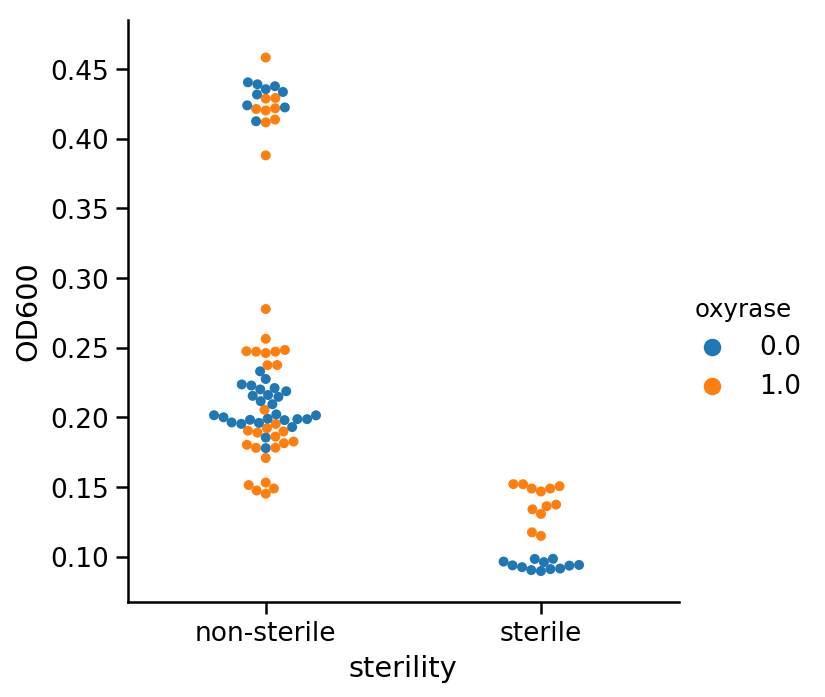

In [20]:
g = sns.catplot(data=data,x="sterility",y="OD600",hue="oxyrase",kind="swarm")

There are two populations within the `'non-sterile'` group. What could explain the difference between those two groups? Probably some combination of the `nitrate` and `tungstate` in the media. Let's break the plot into two plots, based on the nitrate concentration:

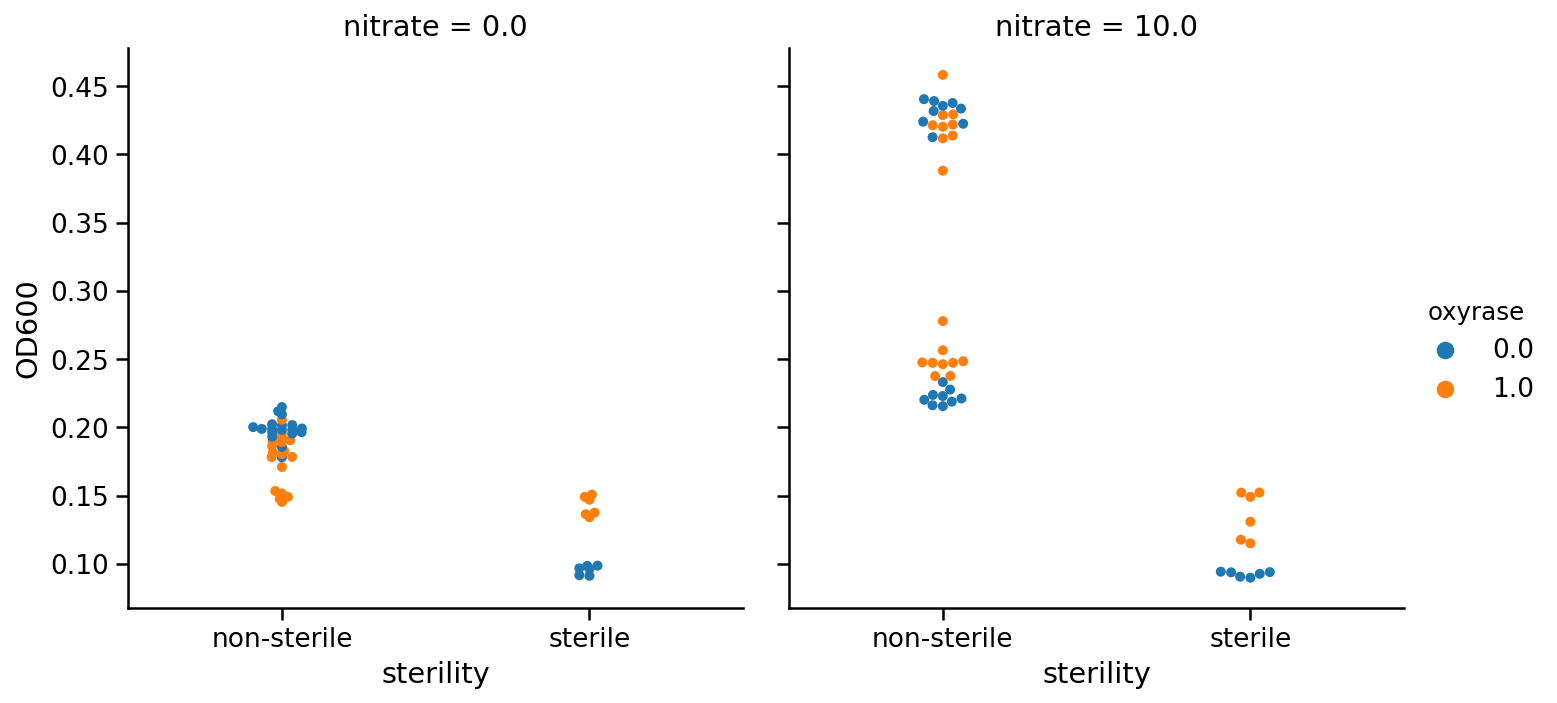

In [21]:
g = sns.catplot(data=data,x="sterility",y="OD600",hue="oxyrase",col='nitrate',kind="swarm")

This is where `catplot` really starts to shine—look how easily we were able to go from one plot to several small plots (or "facets"). We can go further too---let's make two rows of plots, one for each tungstate concentration:

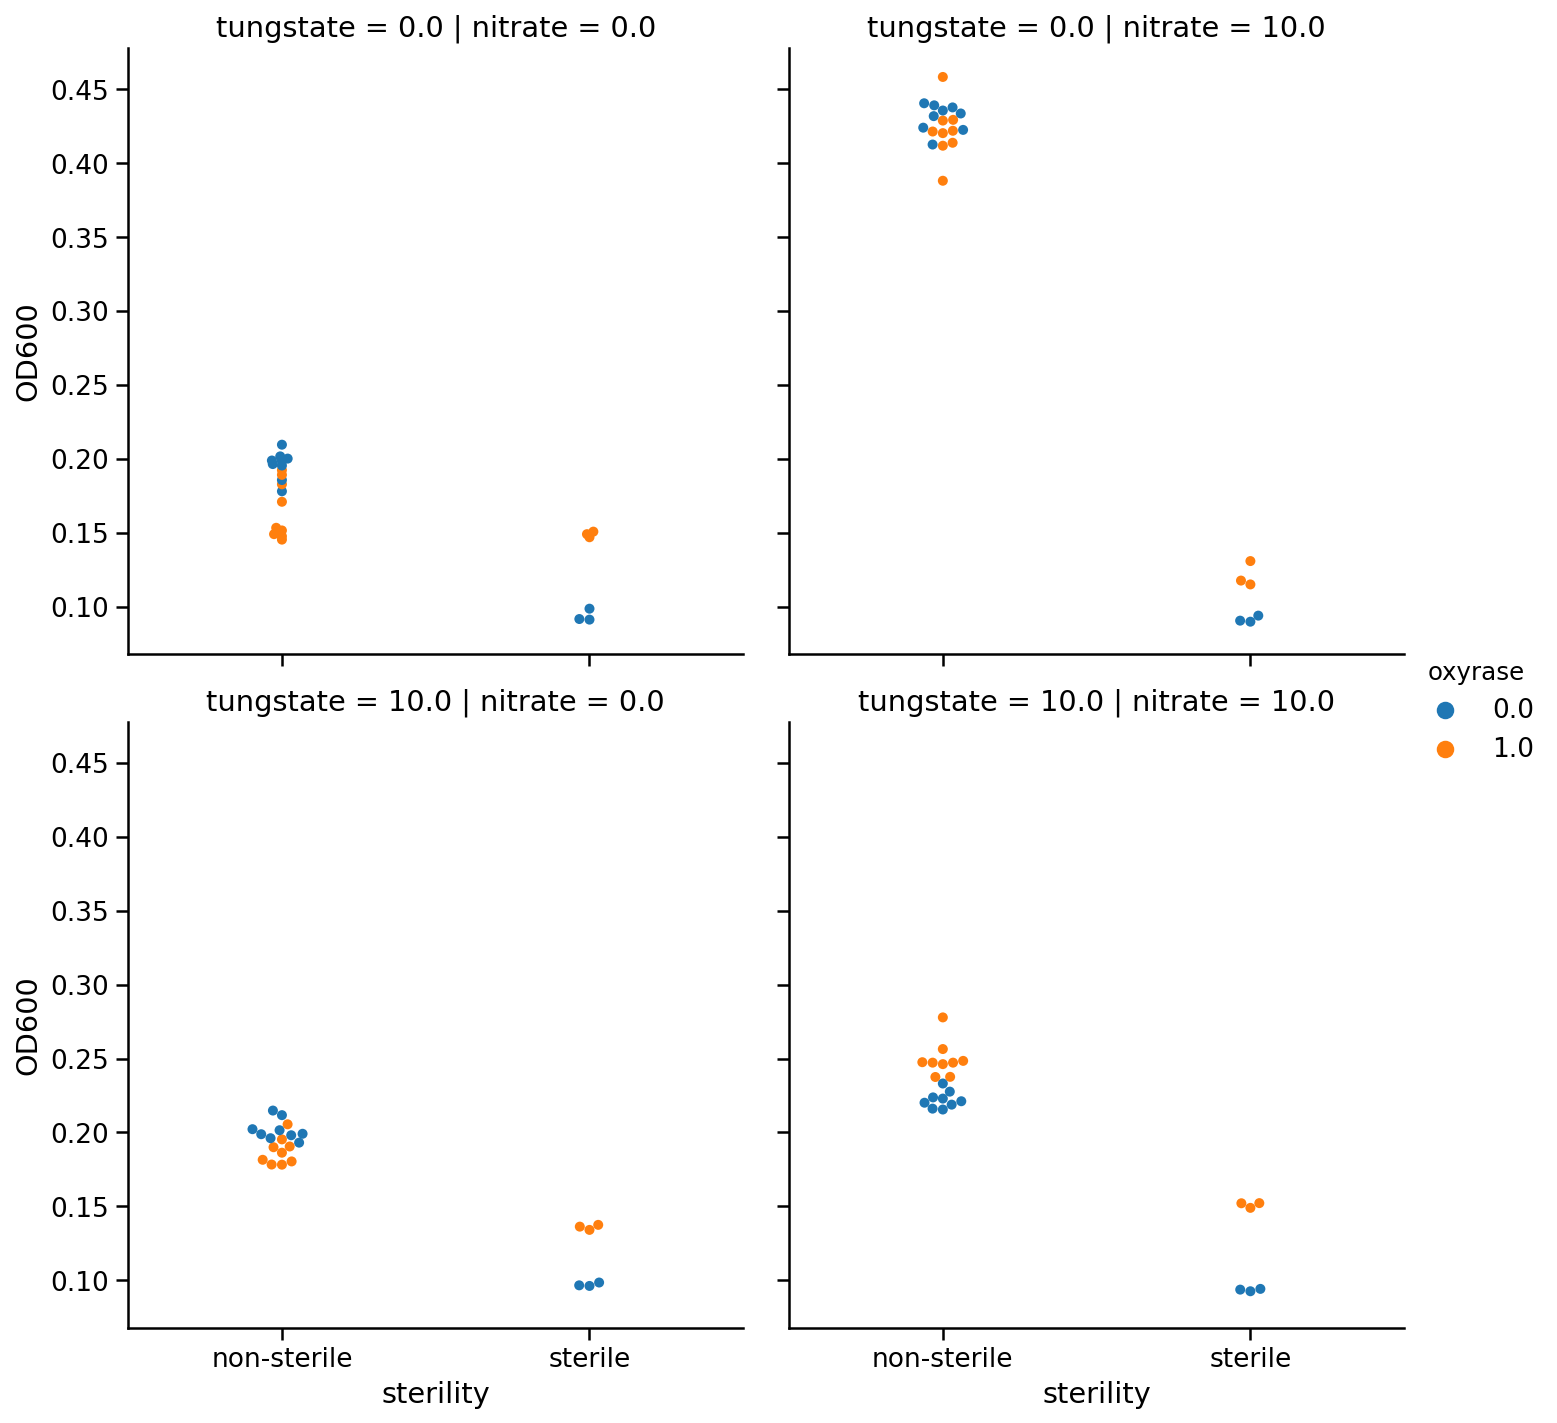

In [22]:
g = sns.catplot(data=data,x="sterility",y="OD600",hue="oxyrase",col='nitrate',row='tungstate',kind="swarm")

What's more, you can easily generalize this code to make comparisons between different variables!

**Exercise:** Switch it up, and adapt this code to plot `oxyrase` in rows, `sterility` in columns, `nitrate` on the x-axis, and `tungstate` concentration on different colors:

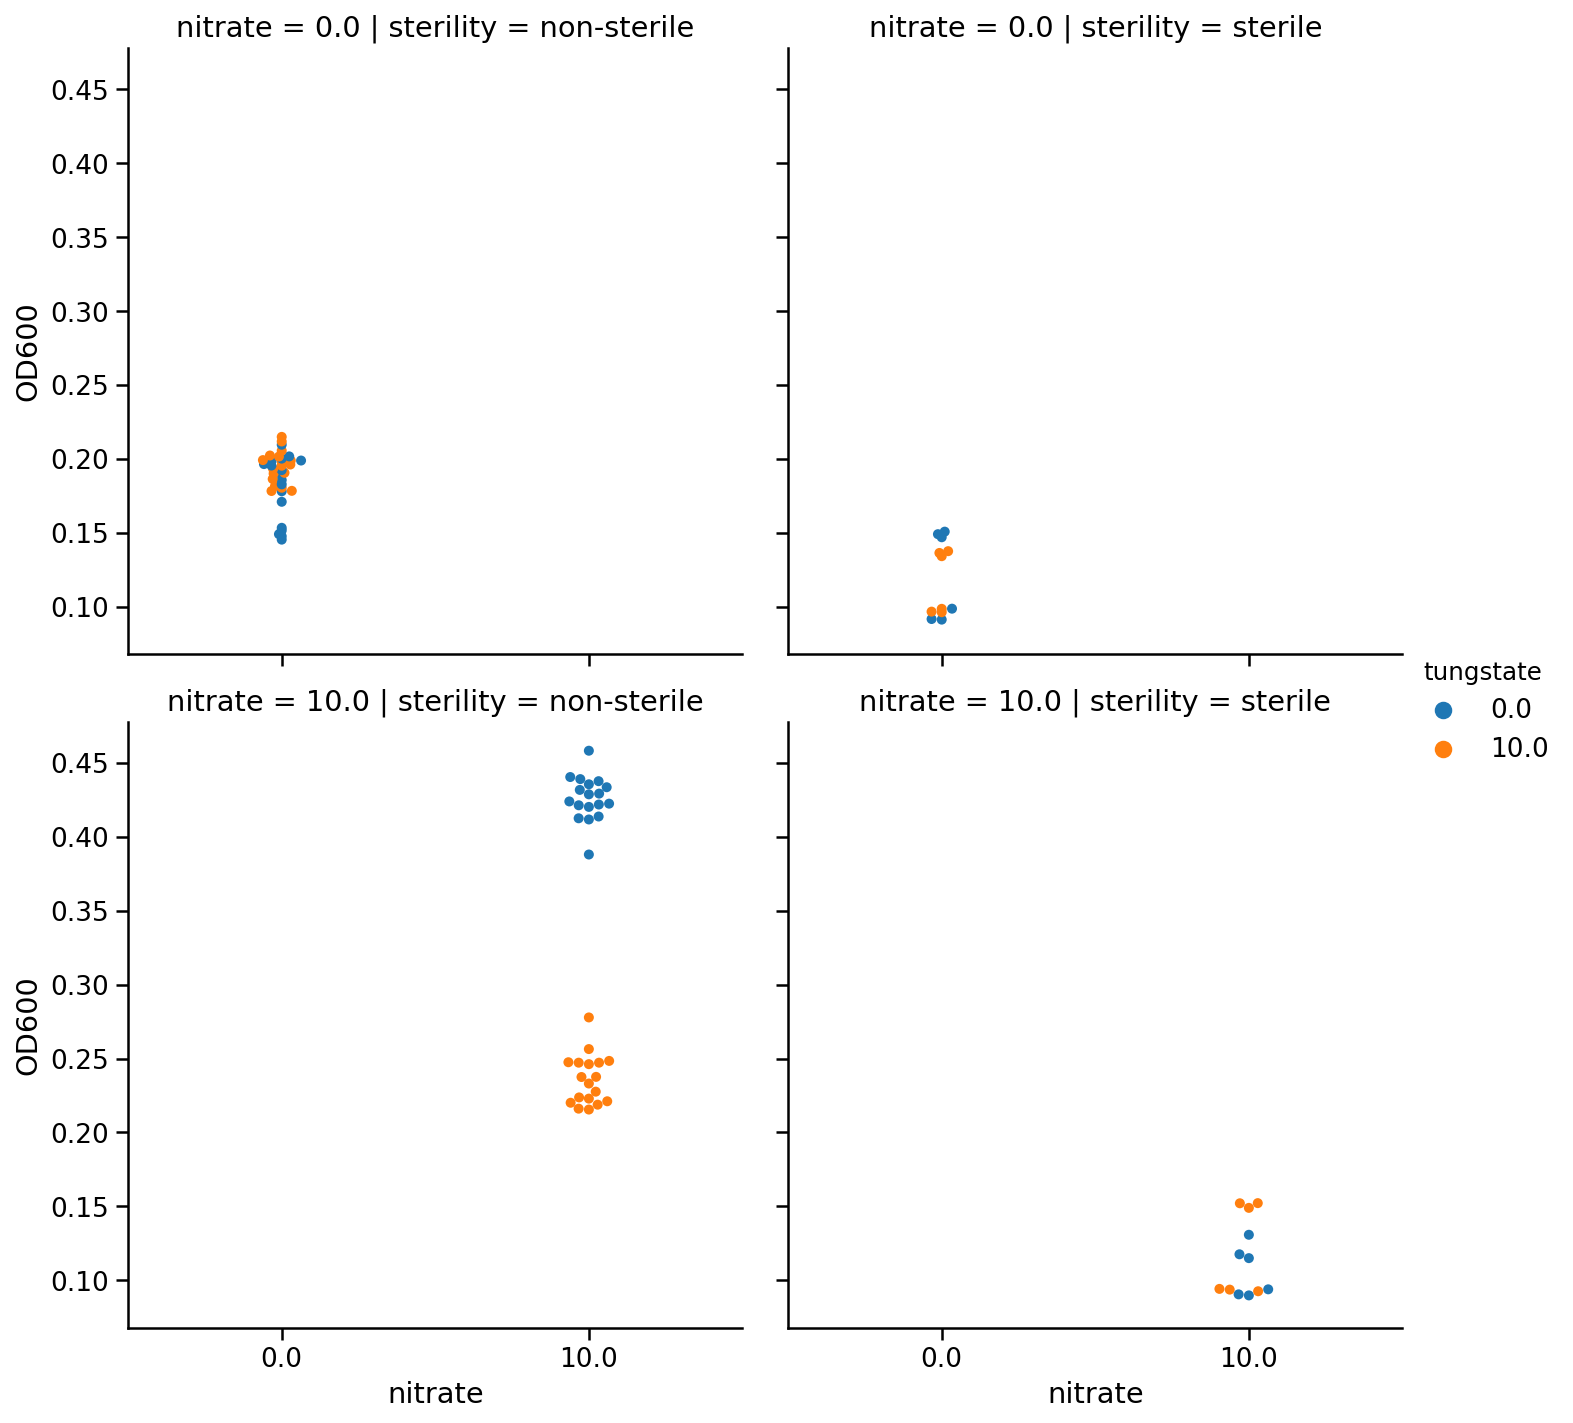

In [23]:
g = sns.catplot(data=data,x="nitrate",y="OD600",hue="tungstate",col='sterility',row='nitrate',kind="swarm")

Here are a bunch more example plots I made, using different combinations of variables:

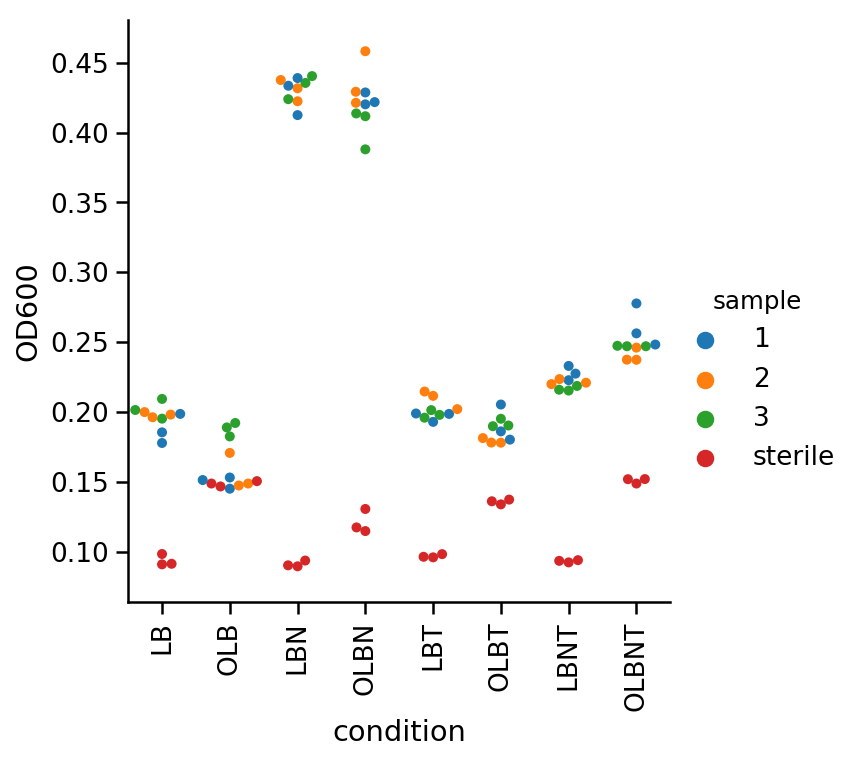

In [24]:
g = sns.catplot(data=data,hue="sample",x="condition",y="OD600",kind="swarm")
g.set_xticklabels(rotation=90)

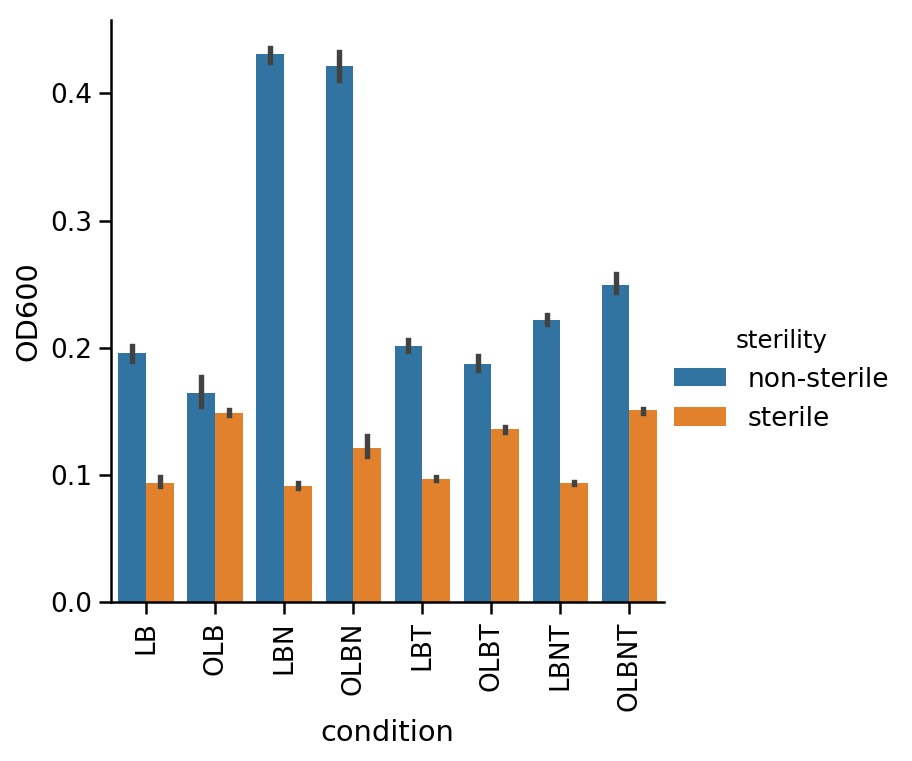

In [25]:
g = sns.catplot(data=data,hue="sterility",x="condition",y="OD600",kind="bar")
g.set_xticklabels(rotation=90)

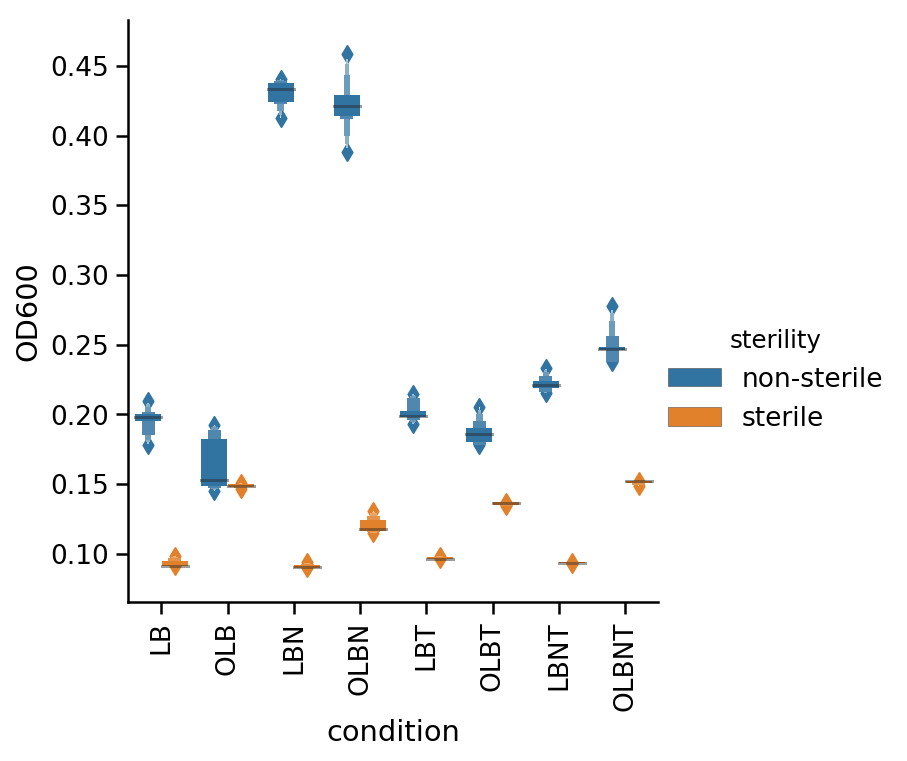

In [26]:
g = sns.catplot(data=data,hue="sterility",x="condition",y="OD600",kind="boxen",linewidth=0.5)
g.set_xticklabels(rotation=90)

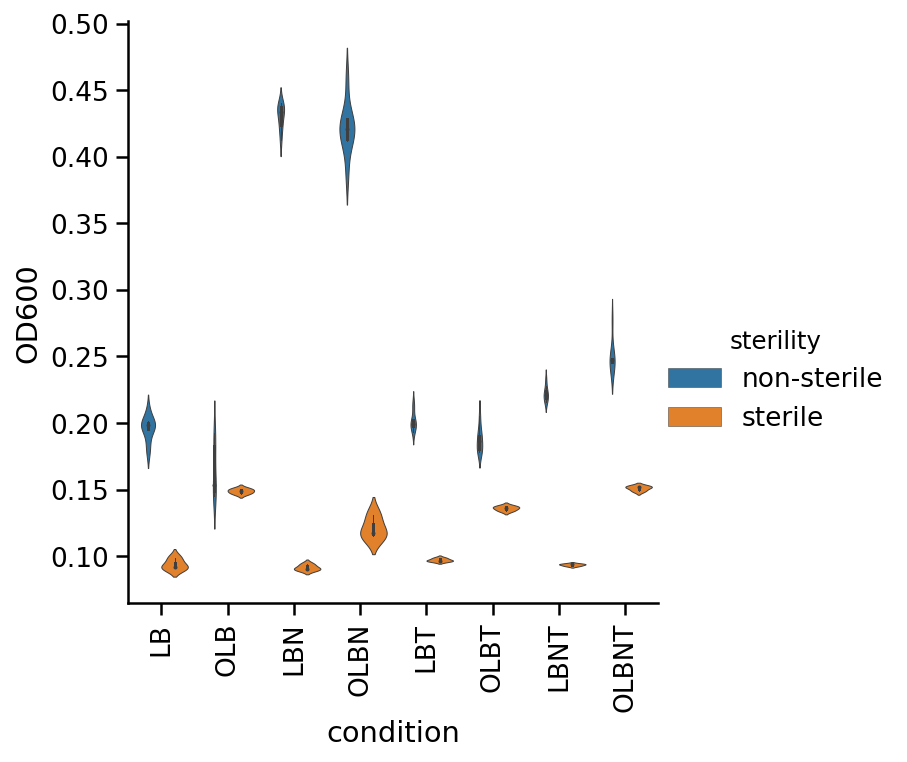

In [27]:
g = sns.catplot(data=data,hue="sterility",x="condition",y="OD600",kind="violin",linewidth=0.5)
g.set_xticklabels(rotation=90)

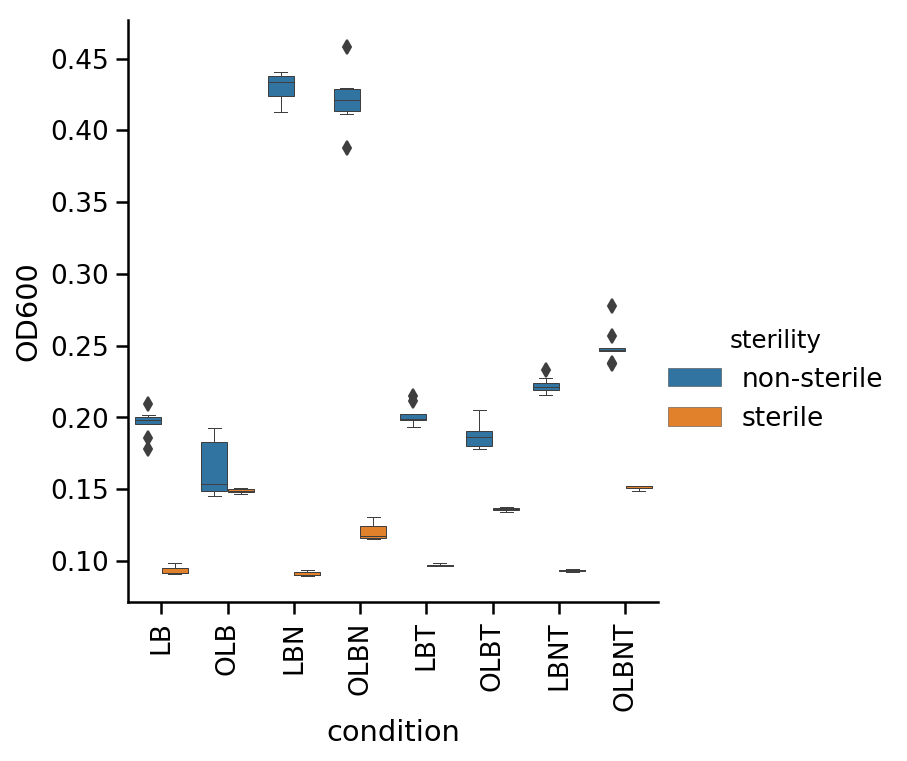

In [28]:
g = sns.catplot(data=data,hue="sterility",x="condition",y="OD600",kind="box",linewidth=0.5)
g.set_xticklabels(rotation=90)

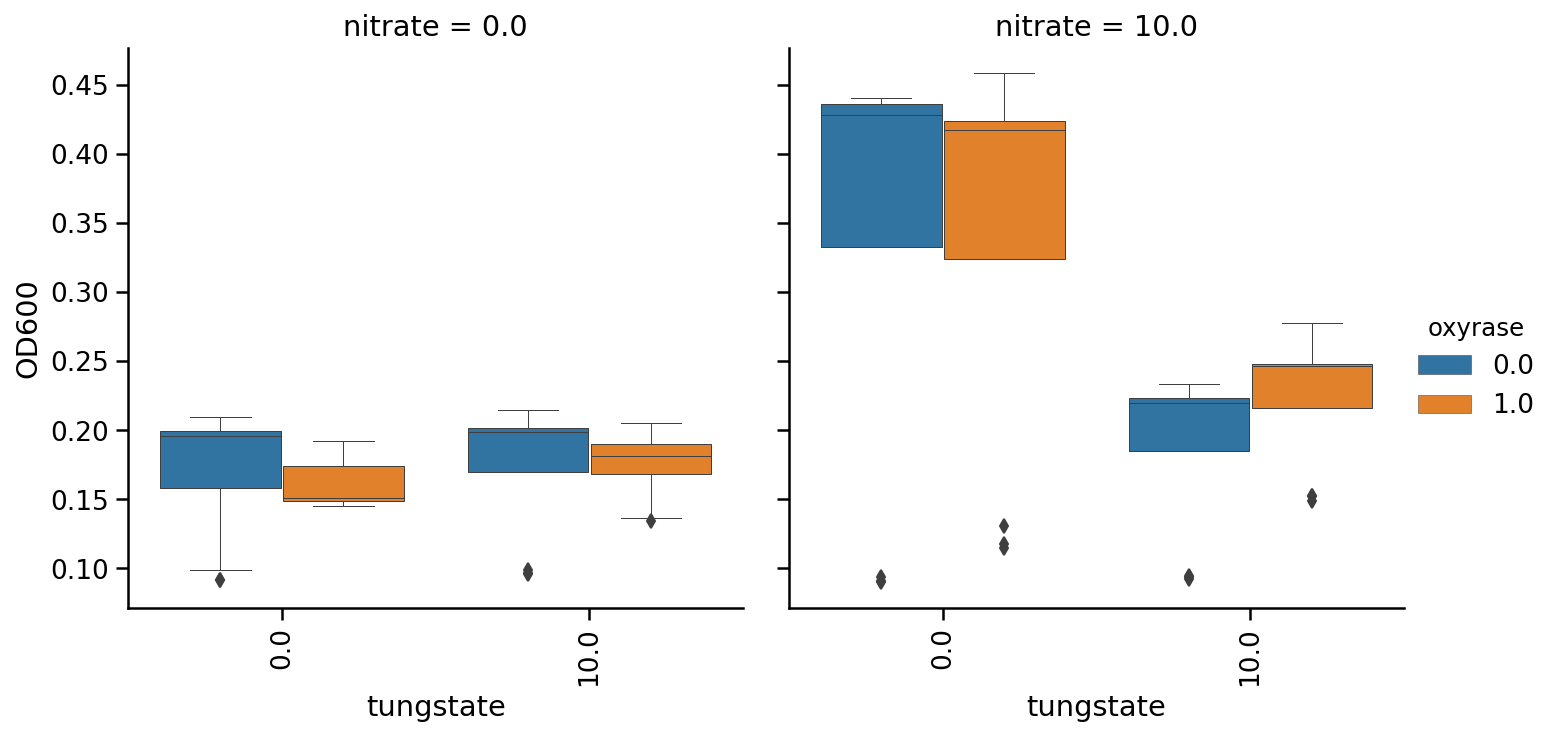

In [29]:
g = sns.catplot(data=data,hue="oxyrase",x="tungstate",y="OD600",col="nitrate", kind="box",linewidth=0.5)
g.set_xticklabels(rotation=90)

To summarize what we learned about `catplot`: 

- use any combination of these these parameters to make plots with different comparisons:

    - `x`: plot this variable on the x-axis; should be a categorical variable
    - `y`: plot this variable on the y-axis; can be continuous or categorical
    - `hue`: color elements of the plot according to this variable; categorical
    - `col`: make columns of subplots according to this variable; categorical
    - `row`: make rows of subplots according to this variable; categorical

Choose the `kind` of plot with `kind`. A [list of different categorical plots is here](https://seaborn.pydata.org/api.html#categorical-plots). Just remove `plot` from the end of the name (i.e. for `boxplot`, use `kind='box'`; for `boxenplot`, use `kind='boxen'`, etc.)

***
One more point before we move on: We can also normalize the data to a certain condition. In this case, let's subtract the `sterile` replicate from the other replicates.

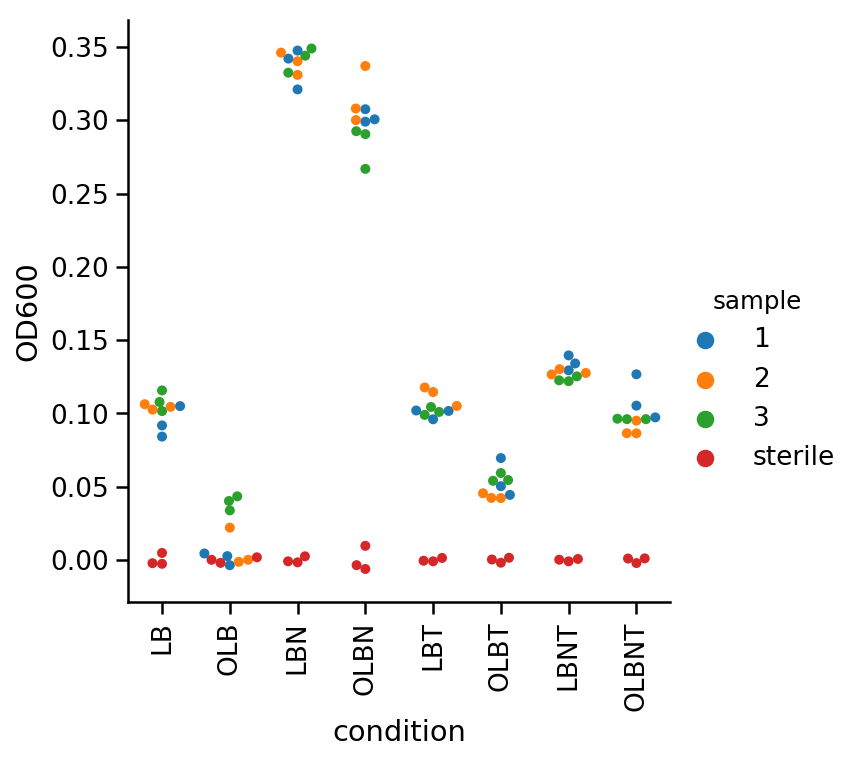

In [30]:
import plates.data
data_normalized_sterile = plates.data.calc_norm(data,value='OD600',
                                    on='sterility',columns=['condition'], 
                                    how=lambda x: x - x.loc['sterile'].mean())

g = sns.catplot(data=data_normalized_sterile,hue="sample",x="condition",y="OD600",kind="swarm",
                   order=["LB","OLB","LBN","OLBN","LBT","OLBT","LBNT","OLBNT"])
g.set_xticklabels(rotation=90)

## Case 2: Amoeba co-incubation

Goal: The goal of this experiment was to explore how co-incubation of two strains of _P. aeruginosa_---PA103 and PA14 FliF were affected by growth in the presence of _Acanthamoeba castelanii_ (*Ac*)

Data: this experiment was performed over multiple 24-hour Tecan runs, then with several measurements taken irregularly so the data is in an Excel spreadsheet that contains several tables---one table for each set of reads. 

### Case 2: Loading & Wrangling
Let's start by building the plate map this time. The general layout of the plate is as follows:

|     _      |   1    |   3    |   2    |   4    |   5    |   6    |     7     |     8     |     9     |     10    |     11    |     12    | *Ac* inoculum |
|------------|--------|--------|--------|--------|--------|--------|-----------|-----------|-----------|-----------|-----------|-----------|---------------|
| **Strain** | PA103  | PA103  | PA103  | PA103  | PA103  | PA103  | PA14 FliF | PA14 FliF | PA14 FliF | PA14 FliF | PA14 FliF | PA14 FliF |               |
| **A**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $0$           |
| **B**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $0$           |
| **C**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $100$         |
| **D**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $100$         |
| **E**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $10^3$        |
| **F**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $10^3$        |
| **G**      | $10^3$ | $10^3$ | $10^3$ | $10^4$ | $10^4$ | $10^4$ | $10^4$    | $10^4$    | $10^4$    | $10^3$    | $10^3$    | $10^3$    | $10^4$        |
| **H**      | $100$  | $100$  | $100$  | $10$   | $10$   | $10$   | $100$     | $100$     | $100$     | $10$      | $10$      | $10$      | $10^4$        |


Numbers in the middle of the table are inoculum of _P. aeruginosa_.


This platemap is a little more complicated than the first case. Check out the documentation of `plates.prog2spec` to see some of the possibilities for handling this plate:

In [31]:
plates.prog2spec?

In [32]:
# build a platemap
platemap = plates.prog2spec({
    "1:6":  { "strain": "PA103" },
    "7:12": { "strain": "PA14 FliF" },
    "A:B":  { "Ac_inoculum": 0 },
    "C:D":  { "Ac_inoculum": 100 },
    "E:F":  { "Ac_inoculum": 10**3 },
    "G:H":  { "Ac_inoculum": 10**4 },
    "A:B,C:D,E:F,G:H": { "Pa_inoculum": [ 
        [ 10**3, 10**3, 10**3, 10**4, 10**4, 10**4, 10**4, 10**4, 10**4, 10**3, 10**3, 10**3 ],
        [ 100,   100,   100,   10,    10,    10,    100,   100,   100,   10,    10,    10,   ]
    ] }
}, include_row_column=True)

platemap

row  column     strain  Ac_inoculum  Pa_inoculum
A1   0.0     0.0      PA103          0.0       1000.0
A2   0.0     1.0      PA103          0.0       1000.0
A3   0.0     2.0      PA103          0.0       1000.0
A4   0.0     3.0      PA103          0.0      10000.0
A5   0.0     4.0      PA103          0.0      10000.0
..   ...     ...        ...          ...          ...
H8   7.0     7.0  PA14 FliF      10000.0        100.0
H9   7.0     8.0  PA14 FliF      10000.0        100.0
H10  7.0     9.0  PA14 FliF      10000.0         10.0
H11  7.0    10.0  PA14 FliF      10000.0         10.0
H12  7.0    11.0  PA14 FliF      10000.0         10.0

[96 rows x 5 columns]

Now we'll separately load each table from the Excel file, verifying that it contains the appropriate number of columns, and that it starts and ends at the right row.

In [33]:
df1 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=2,
                    nrows=98,
                    usecols=plates.letters2row('EC'))
df1

0.0        655.8      1311.6   1967.4     2623.2     3279.1   \
Time [s]                                                                   
Time [hrs]   0.0000   0.182167   0.364333   0.5465   0.728667   0.910861   
Temp. [°C]  25.0000  25.100000  25.000000  25.0000  25.200000  25.300000   
A1           0.0854   0.087400   0.087100   0.0880   0.088200   0.087900   
A2           0.0859   0.088800   0.088600   0.0881   0.087600   0.087100   
A3           0.0882   0.088300   0.088800   0.0891   0.088700   0.088200   
...             ...        ...        ...      ...        ...        ...   
H8           0.1045   0.109300   0.101600   0.1008   0.098400   0.095600   
H9           0.1024   0.104800   0.100400   0.1032   0.099200   0.097900   
H10          0.1066   0.100100   0.096900   0.0966   0.095400   0.095200   
H11          0.0959   0.094000   0.094100   0.0937   0.093400   0.093500   
H12          0.0919   0.091800   0.092200   0.0927   0.092700   0.092400   

              3935.0     4590.8     5246.6     5902.4     ...        80010.7  \
Time [s]                                                  ...                  
Time [hrs]   1.093056   1.275222   1.457389   1.639556    ...      22.225194   
Temp. [°C]  25.200000  25.100000  24.900000  25.100000    ...      25.200000   
A1           0.088600   0.087900   0.087500   0.088100    ...       0.430300   
A2           0.087300   0.089000   0.086600   0.087600    ...       0.438700   
A3           0.088200   0.088000   0.087400   0.088400    ...       0.449500   
...               ...        ...        ...        ...    ...            ...   
H8           0.097700   0.095500   0.096600   0.096900    ...       0.140800   
H9           0.098100   0.097500   0.097700   0.097600    ...       0.150000   
H10          0.096100   0.095500   0.095300   0.093900    ...       0.118400   
H11          0.094700   0.093900   0.093600   0.094000    ...       0.112100   
H12          0.093000   0.092800   0.091800   0.092900    ...       0.109600   

              80666.5    81322.3    81978.1    82633.9    83289.7    83945.5  \
Time [s]                                                                       
Time [hrs]  22.407361  22.589528  22.771694  22.953861  23.136028  23.318194   
Temp. [°C]  25.400000  25.100000  25.100000  25.300000  25.300000  25.300000   
A1           0.434700   0.442600   0.449800   0.452300   0.459100   0.466100   
A2           0.445500   0.452300   0.459200   0.464300   0.471900   0.473800   
A3           0.453500   0.463200   0.465700   0.468600   0.480400   0.480500   
...               ...        ...        ...        ...        ...        ...   
H8           0.143900   0.148000   0.152300   0.156000   0.160600   0.164300   
H9           0.152800   0.157300   0.161900   0.165900   0.170500   0.174400   
H10          0.119300   0.121800   0.124600   0.126500   0.129300   0.130600   
H11          0.112800   0.113200   0.113600   0.115600   0.116200   0.118800   
H12          0.110800   0.111500   0.112700   0.113600   0.114200   0.115200   

              84601.3    85257.1    85912.9  
Time [s]                                     
Time [hrs]  23.500361  23.682528  23.864694  
Temp. [°C]  25.300000  25.300000  25.400000  
A1           0.472300   0.480600   0.483600  
A2           0.482900   0.489600   0.495800  
A3           0.489100   0.494800   0.503200  
...               ...        ...        ...  
H8           0.168700   0.172000   0.178000  
H9           0.178200   0.182700   0.188600  
H10          0.131500   0.133900   0.137100  
H11          0.118500   0.121100   0.122600  
H12          0.117800   0.119400   0.120900  

[98 rows x 132 columns]

(I did this for each separate table, but for conciseness I am not showing it here)

In [34]:
df2 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=104,
                    nrows=98,
                    usecols=plates.letters2row('EC'))

In [35]:
df3 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=206,
                    nrows=98,
                    usecols=plates.letters2row('CT'))

In [36]:
df4 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=309,
                    nrows=98,
                    usecols=3)

In [37]:
df5 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=412,
                    nrows=98,
                    usecols=3)

In [38]:
df6 = pd.read_excel('./data/5.5.18_growth curve_25C_PYG_121 hrs_Ac + PA103, PA14 FliF_MASTER.xlsx',
                    index_col=0,
                    header=514,
                    nrows=98,
                    usecols=4)

This code looks complicated, but it's very similar to what we did for the first example: for each table, we'll convert into a tidy format, then merge with the platemap. There are a few more steps here, including extracting the temperature data and converting the times from seconds to hours

In [39]:
offset = 0

# make a list of processed `DataFrame`s that will be combined together at the end
dfs = []

# make a list of temperatures which will be combined together at the end
temps = []

# for each of the consecutive 24-hour reads
for df in [df1, df2, df3]:
    
    # Extract temperature vs. time as separate variable, then drop (delete)
    # it from the main data frame
    temp = df.loc['Temp. [°C]',:]
    temp.index = (temp.index / 3600) + offset
    temps.append(temp)
    df = df.drop('Temp. [°C]')

    # likewise, extract the hours row that Carrie calculated;
    # we'll re-calculate it to check
    time_h = df.loc['Time [hrs]',:]
    df = df.drop('Time [hrs]')

    # convert columns to hours, and add offset
    df.columns = (df.columns / 3600) + offset
    
    # check that Carrie's calculation of the hours is correct
    assert np.allclose(df.columns.values,time_h.values)

    # the offset for the next table will be the last time point for this table
    offset = df.columns[-1]

    # collect df into "tidy" format, with one row per observation, 
    # one column for each variable (well, time, OD600)
    df.columns = df.columns.rename('time')
    df.index = df.index.rename('well')
    df = df.reset_index()
    df = df.melt(id_vars=['well'],value_name='OD600')
    
    # join platemap to the raw data
    df = pd.merge(df,platemap, how='inner', left_on='well',right_index=True)
    
    dfs.append(df)
    
# for each of the 
for df, offset in zip([df4, df5, df6], [88.5, 112, 121]):
    
    # Extract temperature vs. time as separate variable, then drop (delete)
    # it from the main data frame
    temp = df.loc['Temp. [°C]',:]
    temp.index = (temp.index / 3600) + offset
    temps.append(temp)
    df = df.drop('Temp. [°C]')
    
    # likewise, extract the hours row
    time_h = df.loc['Time [hrs]',:]
    df = df.drop('Time [hrs]')

    # convert columns to hours, and add offset
    df.columns = (df.columns / 3600) + offset

    # check that Carrie's calculation of the hours is correct
    assert np.allclose(df.columns.values,time_h.values)
    
    # collect df into "tidy" format, with one row per observation, 
    # one column for each variable (well, time, OD600)
    df.columns = df.columns.rename('time')
    df.index = df.index.rename('well')
    df = df.reset_index()
    df = df.melt(id_vars=['well'],value_name='OD600')
    
    # join platemap to the raw data
    df = pd.merge(df,platemap, how='inner', left_on='well',right_index=True)
    
    dfs.append(df)

temps = pd.concat(temps)
data = pd.concat(dfs)
    
display(data)
display(temps)

well      time   OD600  row  column     strain  Ac_inoculum  Pa_inoculum
0     A1         0  0.0854  0.0     0.0      PA103          0.0       1000.0
96    A1  0.182167  0.0874  0.0     0.0      PA103          0.0       1000.0
192   A1  0.364333  0.0871  0.0     0.0      PA103          0.0       1000.0
288   A1    0.5465  0.0880  0.0     0.0      PA103          0.0       1000.0
384   A1  0.728667  0.0882  0.0     0.0      PA103          0.0       1000.0
..   ...       ...     ...  ...     ...        ...          ...          ...
382  H11   121.146  1.3738  7.0    10.0  PA14 FliF      10000.0         10.0
95   H12       121  0.2391  7.0    11.0  PA14 FliF      10000.0         10.0
191  H12   121.049  0.2787  7.0    11.0  PA14 FliF      10000.0         10.0
287  H12   121.098  0.2763  7.0    11.0  PA14 FliF      10000.0         10.0
383  H12   121.146  0.2778  7.0    11.0  PA14 FliF      10000.0         10.0

[35616 rows x 8 columns]

0.000000      25.0
0.182167      25.1
0.364333      25.0
0.546500      25.0
0.728667      25.2
              ... 
112.364389    25.1
121.000000    24.9
121.048833    25.2
121.097667    25.3
121.146472    25.4
Name: Temp. [°C], Length: 371, dtype: float64

We can compute new columns based on existing columns; let's calculate the multiplicity of infection (MOI):, as well as the log of the inocula:

In [40]:
data['MOI'] = data['Pa_inoculum'] / data['Ac_inoculum']
data['log_MOI'] = np.log10(data['MOI'])
data['log_Pa_inoculum'] = np.log10(data['Pa_inoculum'])
data['log_Ac_inoculum'] = np.log10(data['Ac_inoculum']).apply(lambda x: 0 if x == float('-inf') else x)
data

/Users/caseygrun/miniconda3/envs/kaz_lab_workshop/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


well      time   OD600  row  column     strain  Ac_inoculum  Pa_inoculum  \
0     A1         0  0.0854  0.0     0.0      PA103          0.0       1000.0   
96    A1  0.182167  0.0874  0.0     0.0      PA103          0.0       1000.0   
192   A1  0.364333  0.0871  0.0     0.0      PA103          0.0       1000.0   
288   A1    0.5465  0.0880  0.0     0.0      PA103          0.0       1000.0   
384   A1  0.728667  0.0882  0.0     0.0      PA103          0.0       1000.0   
..   ...       ...     ...  ...     ...        ...          ...          ...   
382  H11   121.146  1.3738  7.0    10.0  PA14 FliF      10000.0         10.0   
95   H12       121  0.2391  7.0    11.0  PA14 FliF      10000.0         10.0   
191  H12   121.049  0.2787  7.0    11.0  PA14 FliF      10000.0         10.0   
287  H12   121.098  0.2763  7.0    11.0  PA14 FliF      10000.0         10.0   
383  H12   121.146  0.2778  7.0    11.0  PA14 FliF      10000.0         10.0   

          MOI   log_MOI  log_Pa_inoculum  log_Ac_inoculum  
0         inf       inf              3.0              0.0  
96        inf       inf              3.0              0.0  
192       inf       inf              3.0              0.0  
288       inf       inf              3.0              0.0  
384       inf       inf              3.0              0.0  
..        ...       ...              ...              ...  
382  0.001000 -3.000000              1.0              4.0  
95   0.001000 -3.000000              1.0              4.0  
191  0.001000 -3.000000              1.0              4.0  
287  0.001000 -3.000000              1.0              4.0  
383  0.001000 -3.000000              1.0              4.0  

[35616 rows x 12 columns]

### Case 2: Plotting

The data in this example is different from the first case in a crucial way: the time axis is [continuous](https://en.wikipedia.org/wiki/Continuous_function), rather than [categorical (discrete)](https://en.wikipedia.org/wiki/Categorical_variable). Rather than using `catplot`, we'll meet a new function called [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot).

Let's start by looking at a single condition: PA103, no *AC*, with an inoculum of 1000 

In [41]:
data.query("strain == 'PA103' & Ac_inoculum == 0 & Pa_inoculum == 1000")

well      time   OD600  row  column strain  Ac_inoculum  Pa_inoculum  MOI  \
0     A1         0  0.0854  0.0     0.0  PA103          0.0       1000.0  inf   
96    A1  0.182167  0.0874  0.0     0.0  PA103          0.0       1000.0  inf   
192   A1  0.364333  0.0871  0.0     0.0  PA103          0.0       1000.0  inf   
288   A1    0.5465  0.0880  0.0     0.0  PA103          0.0       1000.0  inf   
384   A1  0.728667  0.0882  0.0     0.0  PA103          0.0       1000.0  inf   
..   ...       ...     ...  ...     ...    ...          ...          ...  ...   
289   A2   121.146  1.5427  0.0     1.0  PA103          0.0       1000.0  inf   
2     A3       121  1.5457  0.0     2.0  PA103          0.0       1000.0  inf   
98    A3   121.049  1.5383  0.0     2.0  PA103          0.0       1000.0  inf   
194   A3   121.098  1.6135  0.0     2.0  PA103          0.0       1000.0  inf   
290   A3   121.146  1.5997  0.0     2.0  PA103          0.0       1000.0  inf   

     log_MOI  log_Pa_inoculum  log_Ac_inoculum  
0        inf              3.0              0.0  
96       inf              3.0              0.0  
192      inf              3.0              0.0  
288      inf              3.0              0.0  
384      inf              3.0              0.0  
..       ...              ...              ...  
289      inf              3.0              0.0  
2        inf              3.0              0.0  
98       inf              3.0              0.0  
194      inf              3.0              0.0  
290      inf              3.0              0.0  

[1113 rows x 12 columns]

[`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot) is the continuous cousin of `catplot`. Like `catplot`, we pass `relplot` our `data`, and then map figure aesthetics (such as `x`, `y`, and `hue`) to columns in our `data`. For example, let's map the time course of a single amoeba infection

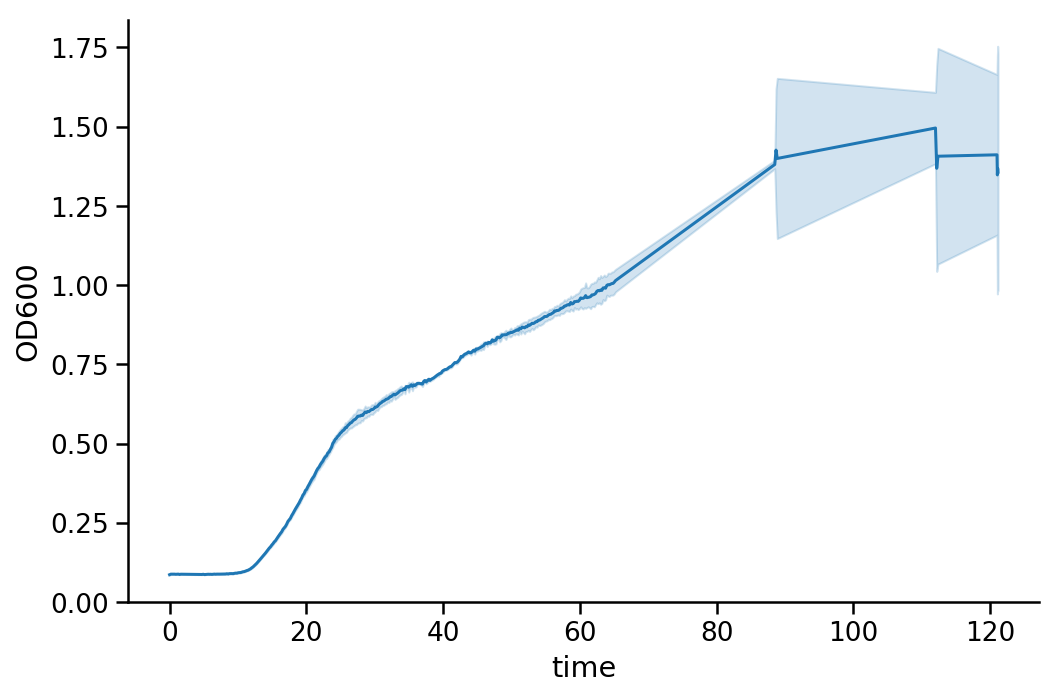

In [42]:
sns.relplot(data=data.query("strain == 'PA103' & Ac_inoculum == 0 & Pa_inoculum == 1000"),
             x='time',y='OD600',
             # stretch the plot a bit so we can see earlier timepoints more easily.
             aspect=1.5,
             # by default, Seaborn draws confidence intervals by Bootstrap sampling
             # <https://en.wikipedia.org/wiki/Bootstrapping_(statistics)>. This gets 
             # really slow with `relplot`, so we'll ask it to draw confidence intervals
             # using the standard deviation instead. To go back to bootstrapping, just remove
             # this line. It'll take much longer to plot!
             ci='sd',
             kind='line'
            )

Turns out we can set `hue` on `relplot`, just like we did for `factorplot`; let's look at different starting inocula of PA103:

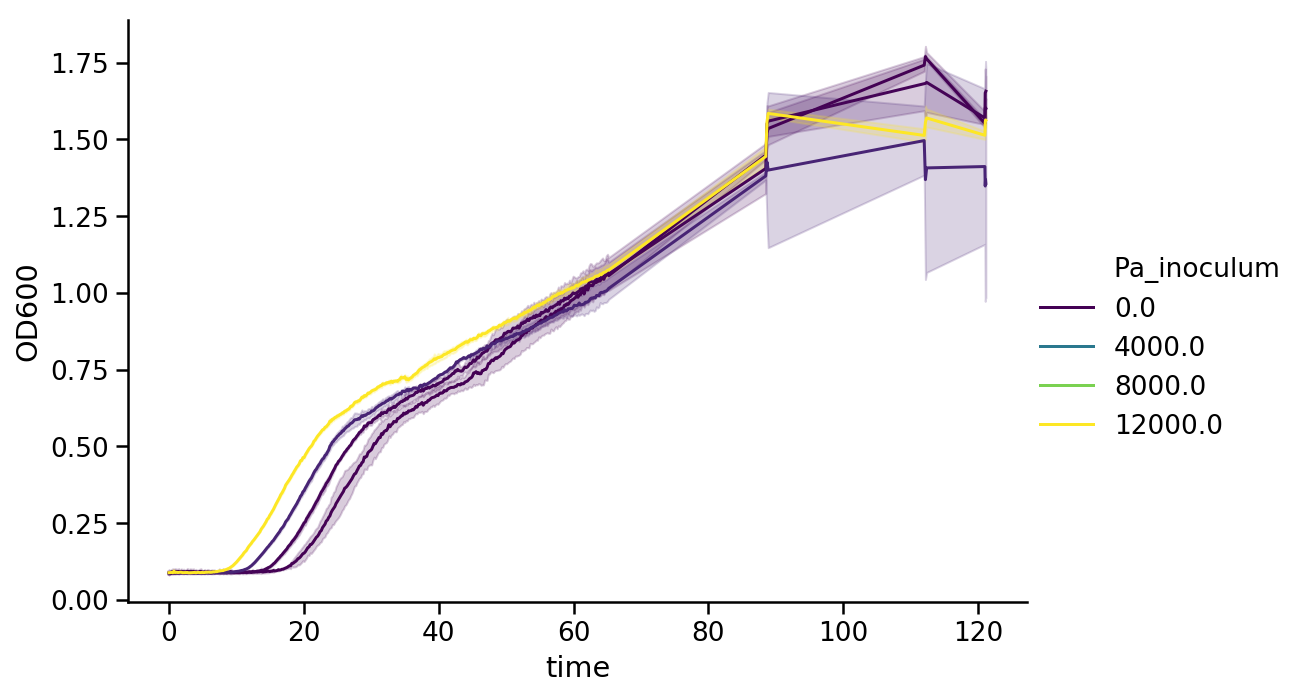

In [43]:
sns.relplot(data=data.query("strain == 'PA103' & Ac_inoculum == 0"),
            x='time',y='OD600',hue='Pa_inoculum',
            aspect=1.5,
            palette='viridis',
            ci='sd',kind='line')

This is probably not what you expected, but it makes sense when you realize that in `relplot`, everything is continuous. Under the hood, Seaborn is mapping values of your `hue` variable (`Pa_inoculum`) to a *continuous* linear scale. This turns out to be a very useful feature when the variable mapped to `hue` has lots of values---rather than showing each level of the hue as a separate entry in the legend, it can show a sampling of values.

However, in this case it would be more helpful to scale the hues used to represent values of `Pa_inoculum` to a log scale, so that there's just as clear a difference between 1000 and 100 as between $10^4$ and 1000. 

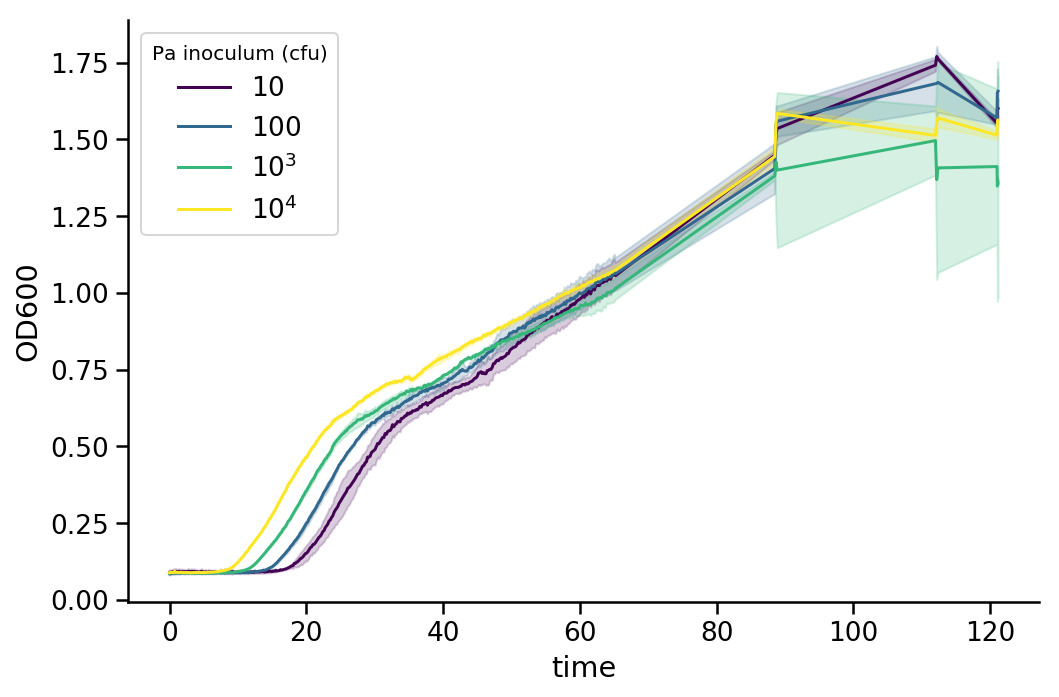

In [44]:
from matplotlib.colors import LogNorm
sns.relplot(data=data.query("strain == 'PA103' & Ac_inoculum == 0"),
            x='time',y='OD600',hue='Pa_inoculum', 
            # normalize the colors to the log of the inoculum
            hue_norm=LogNorm(),
            aspect = 1.5,
            palette='viridis', 
            # hide the legend, we'll draw it ourself later
            legend=False,
            ci='sd',kind='line')

# override the legend with a nicer display of the inocula
plt.gca().legend(title='Pa inoculum (cfu)',labels=['$10$','$100$','$10^3$','$10^4$']);

There are other ["normalization functions" for colormaps](https://matplotlib.org/users/colormapnorms.html) provided by [matplotlib](https://matplotlib.org). 

`relplot` has a few other tricks up its sleeve. You can draw spaghetti plots like this:

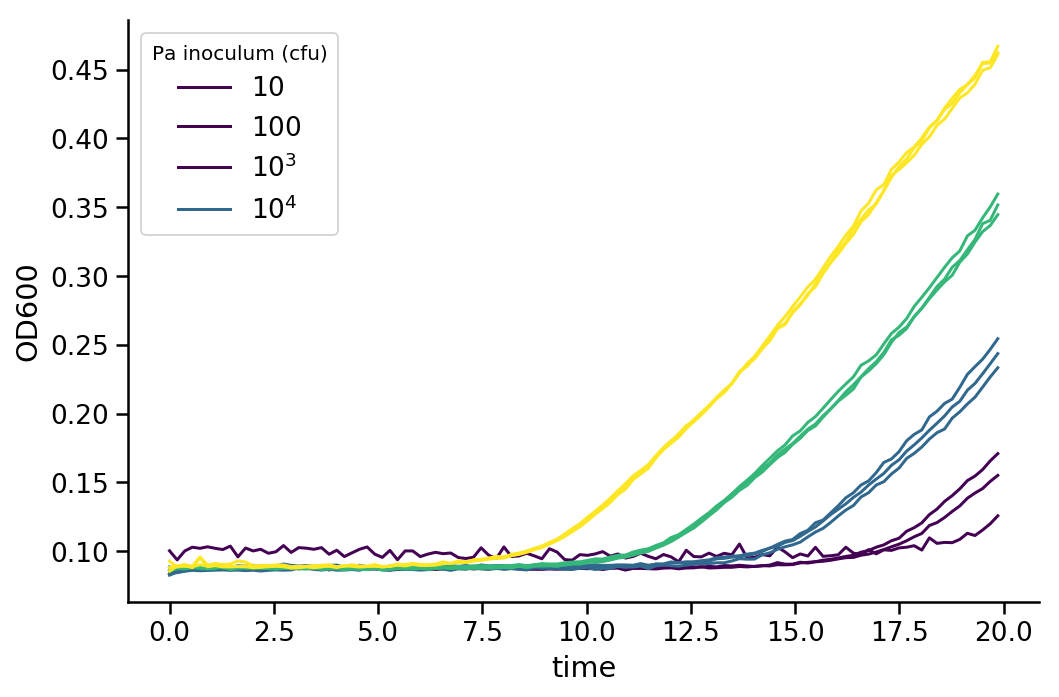

In [45]:
from matplotlib.colors import LogNorm
sns.relplot(data=data.query("strain == 'PA103' & Ac_inoculum == 0 & time < 20"),
            x='time',y='OD600',hue='Pa_inoculum',     
            hue_norm=LogNorm(),
            
            # plot each well as a distinct sampling unit
            units='well',
            # don't sum over wells
            estimator = None,

            aspect = 1.5,
            palette='viridis', 
            legend=False,
            ci='sd',kind='line')

# override the legend with a nicer display of the inocula
plt.gca().legend(title='Pa inoculum (cfu)',labels=['$10$','$100$','$10^3$','$10^4$']);

So far, we have been using `kind='line'` to show a [`lineplot`](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot). Just like with `catplot`, you can change the `kind` of a `relplot` to to `'scatter'` to show a [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot) instead of a `lineplot`:

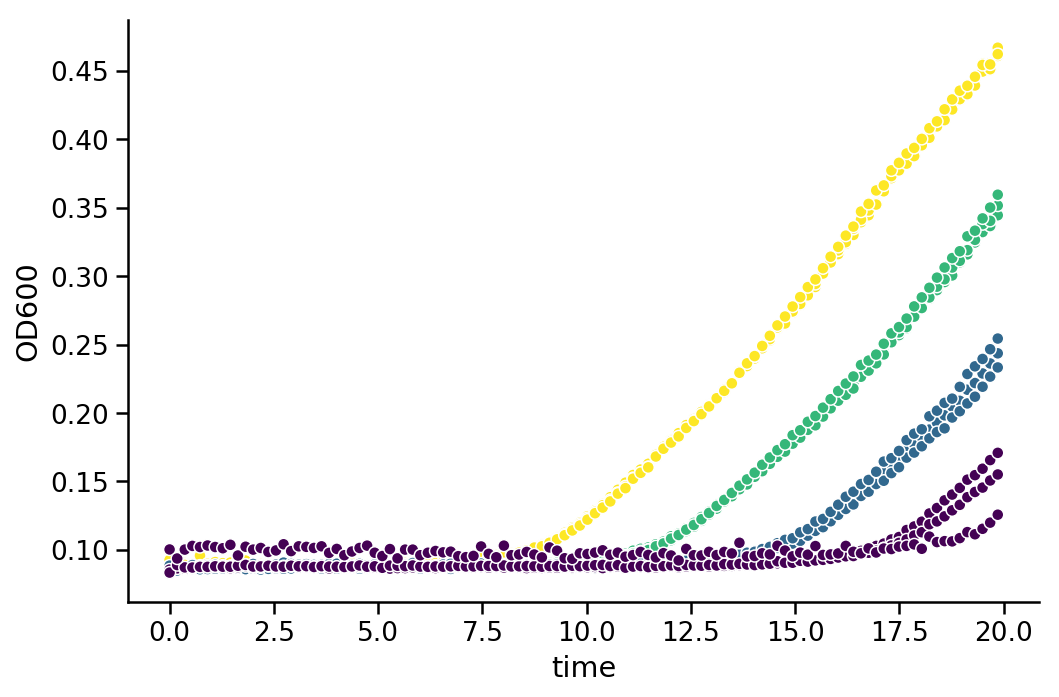

In [46]:
from matplotlib.colors import LogNorm
sns.relplot(data=data.query("strain == 'PA103' & Ac_inoculum == 0 & time < 20"),
            x='time',y='OD600',hue='Pa_inoculum',     
            hue_norm=LogNorm(),

            aspect = 1.5,
            palette='viridis', 
            legend=False,
            ci='sd',kind='scatter')

Finally, there are other aesthetics with `relplot`; you can map continuous or categorical variables to the `size` of the lines (or the size of the points for `scatterplot`); you can map categorical variables to the `style` to change the line style (or marker style for `scatterplot`):

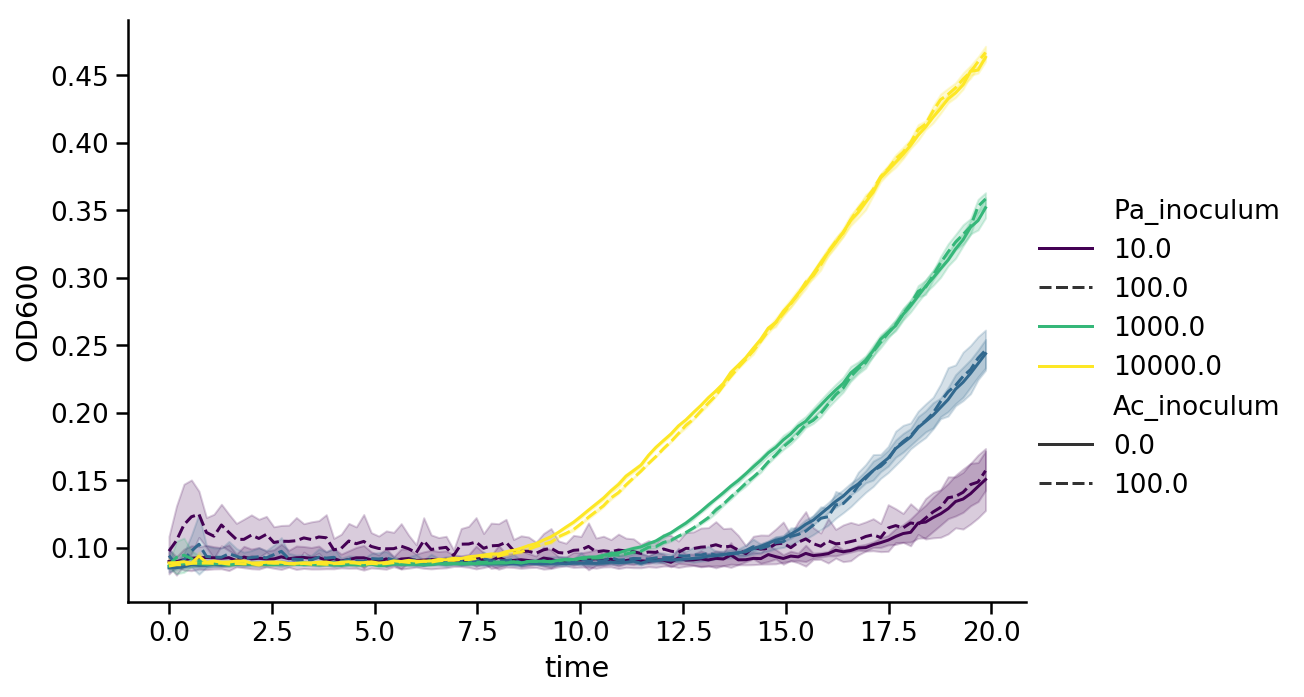

In [47]:
from matplotlib.colors import LogNorm
sns.relplot(data=data.query("strain == 'PA103' & Ac_inoculum in [0, 100] & time < 20"),
            x='time',y='OD600',hue='Pa_inoculum',
            
            # plot different inocula of _Ac_ with different line styles
            style='Ac_inoculum',
            hue_norm=LogNorm(),

            aspect = 1.5,
            palette='viridis', 
            legend='full',
            ci='sd',kind='line')

Remember, you can also get help on `relplot` here:

In [48]:
sns.relplot?

***
Let's compare PA103 across several MOIs to PA14 FliF. Just like `catplot`, `relplot` can also make "facets," showing different values of a (categorical) variable in different plots.

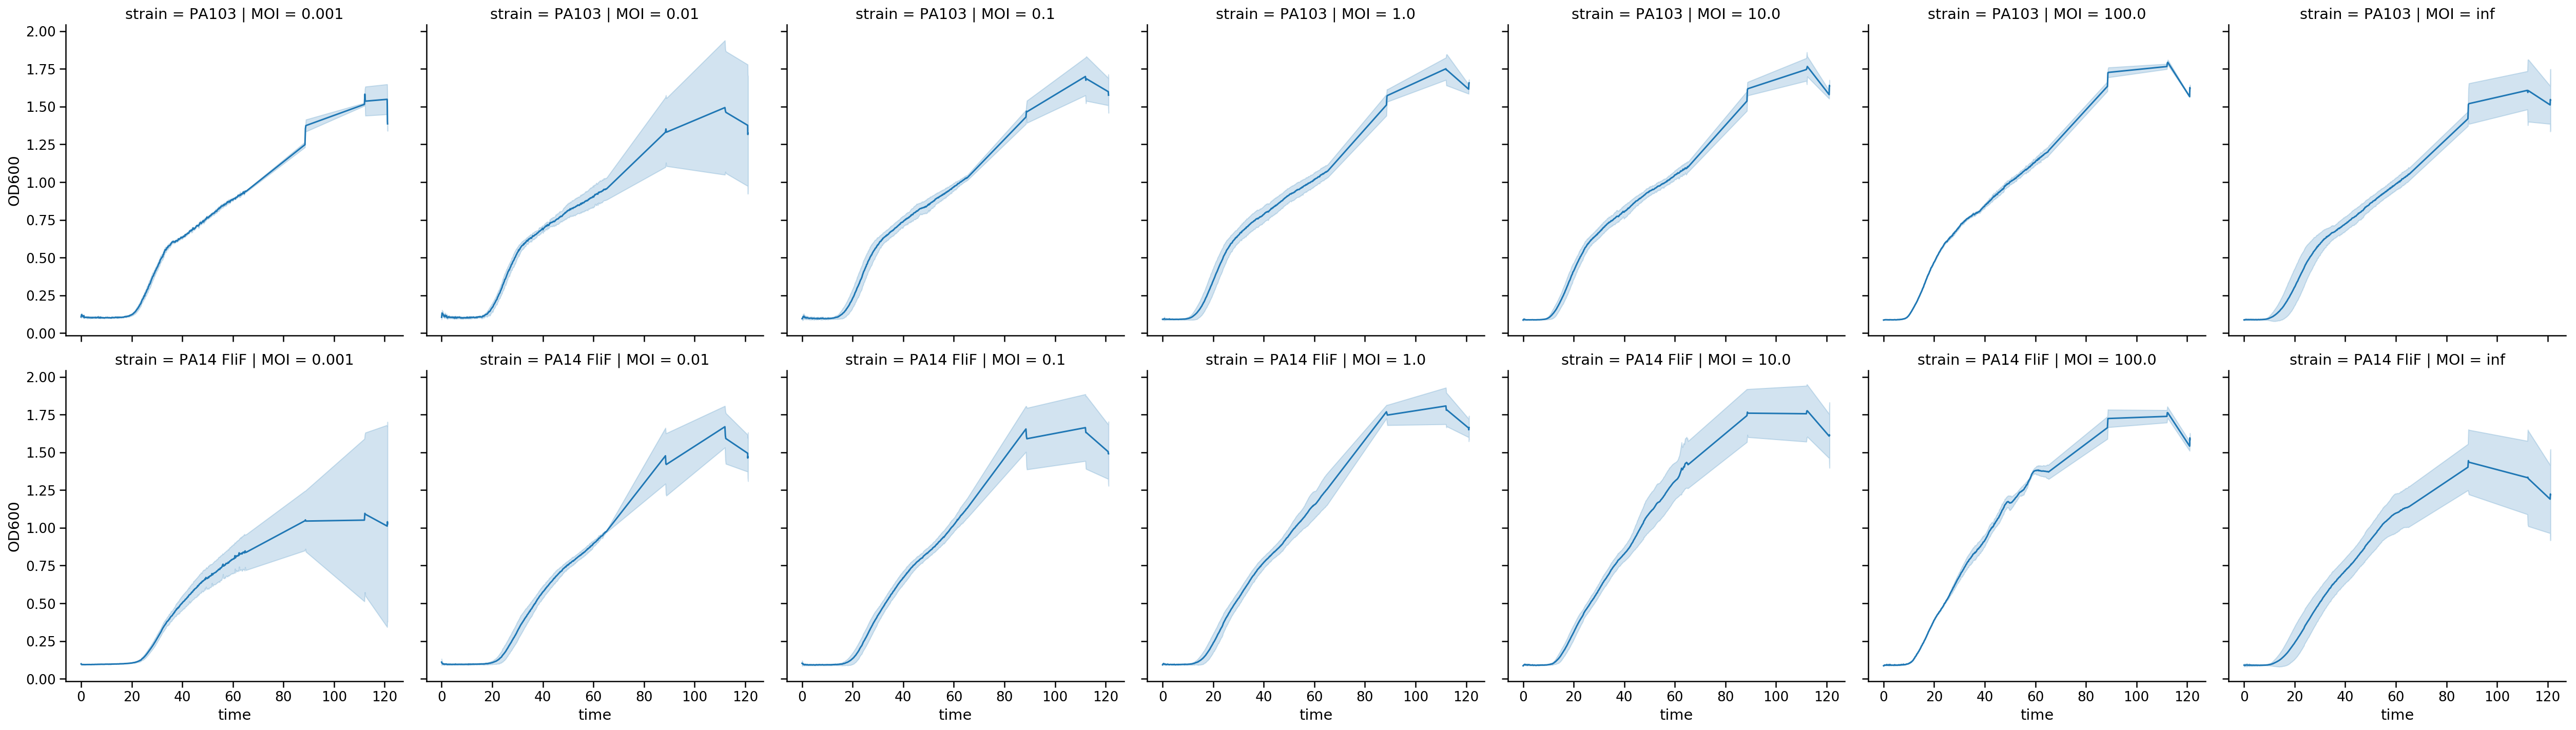

In [49]:
g = sns.relplot(data=data,col='MOI',row='strain',x='time',y='OD600',ci='sd',kind='line')

**Exercise**: instead of showing the two strains in separate rows, plot them as different-colored traces on the same row of plots 

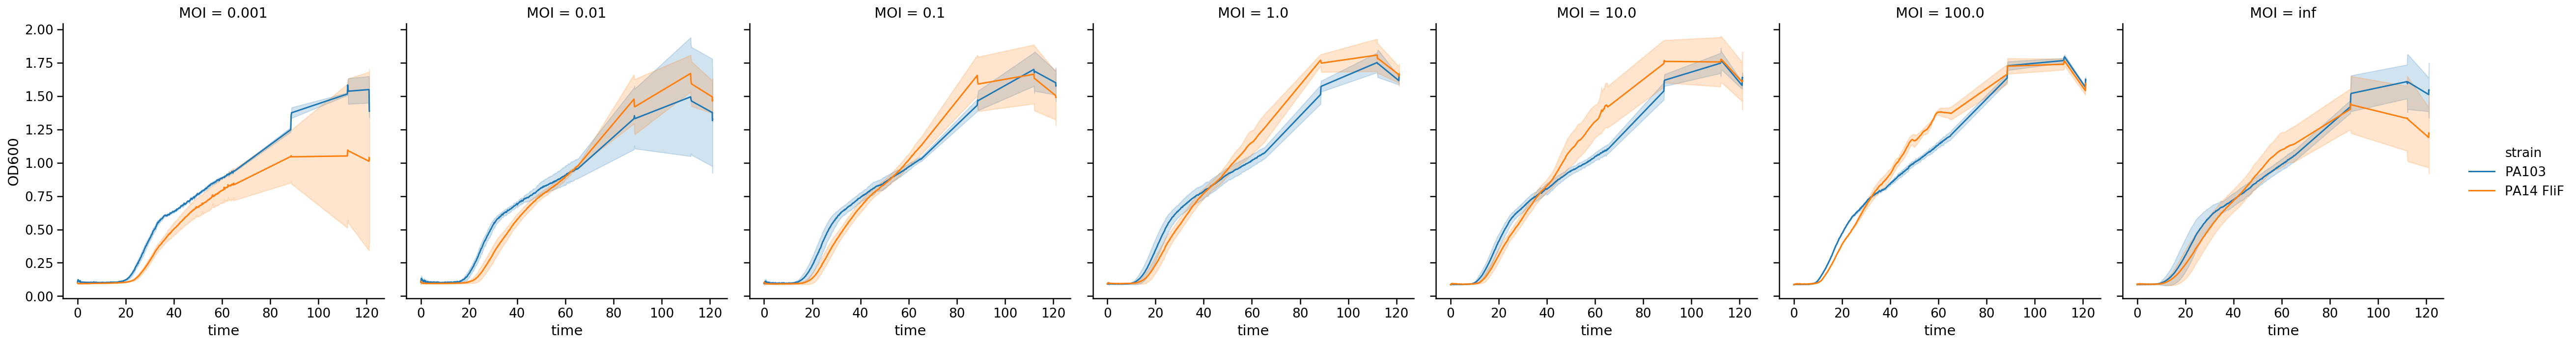

In [50]:
g = sns.relplot(data=data,col='MOI',hue='strain',x='time',y='OD600',ci='sd',kind='line')

***
**Exercise**: Let's compare the behavior of the same strain at different MOIs, by plotting each MOI as a different-colored trace; here's some code to get you started:

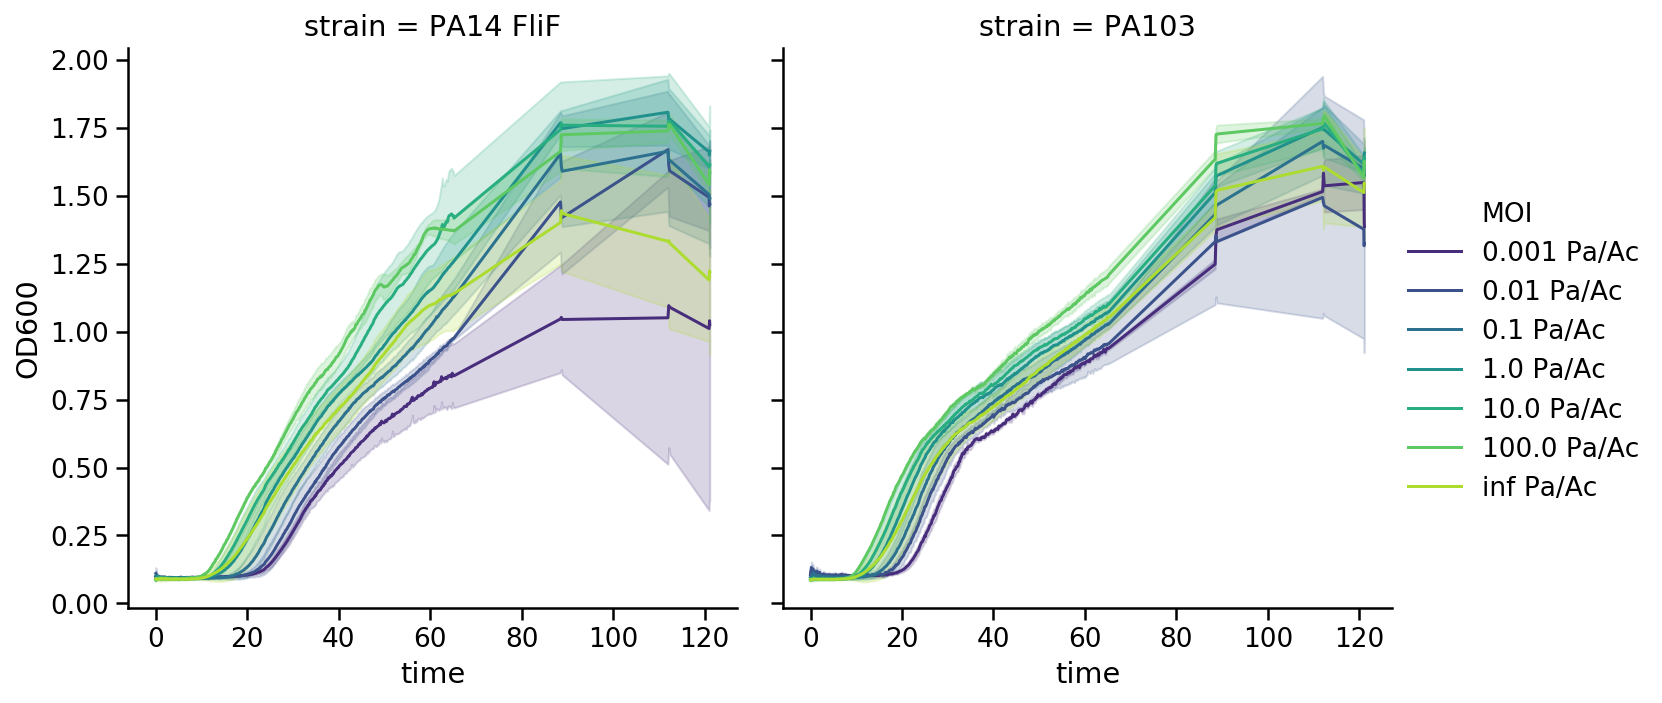

In [51]:
# slight hack: convert the MOI into a string so that the MOI = infinity doesn't mess up color scaling
data_cat = data.copy().sort_values(by='MOI')
data_cat.MOI = data_cat.MOI.astype('str') + ' Pa/Ac'

g = sns.relplot(data=data_cat,
                col='strain',
                hue='MOI', 
                x='time',
                y='OD600',
                ci='sd',
                palette='viridis',
                height=5, kind='line')

Interesting! Notice that MOI = infinity (e.g. no _Ac_) is in the middle, and the bacteria grow faster with some amoeba than with no amoeba. Let's use a different color scale to emphasize this. 

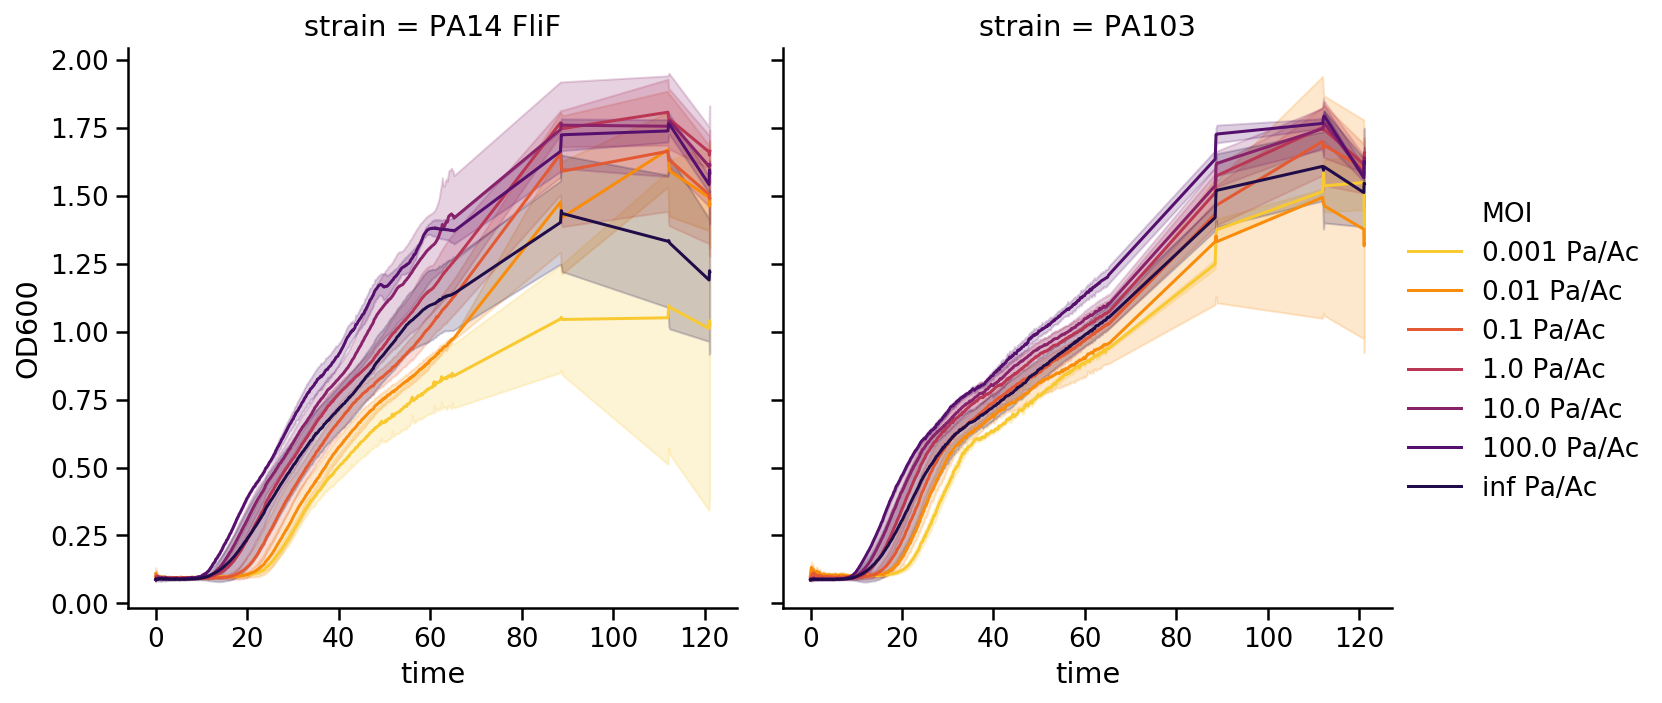

In [69]:
g = sns.relplot(data=data_cat,
                col='strain',
                hue='MOI',
                x='time',
                y='OD600',
                ci='sd',
                palette='inferno_r',
                height=5, kind='line')

I should mention that [color scales must be chosen carefully](https://matplotlib.org/users/colormaps.html) in order to avoid distorting readers (and your own!) perception of your data, which can lead to you drawing incorrect conclusions. 

Let's zoom in on the region of interest: we can use the matplotlib functions [`xlim`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xlim.html) and [`ylim`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ylim.html) to set the limits of the `x` and `y` axes.

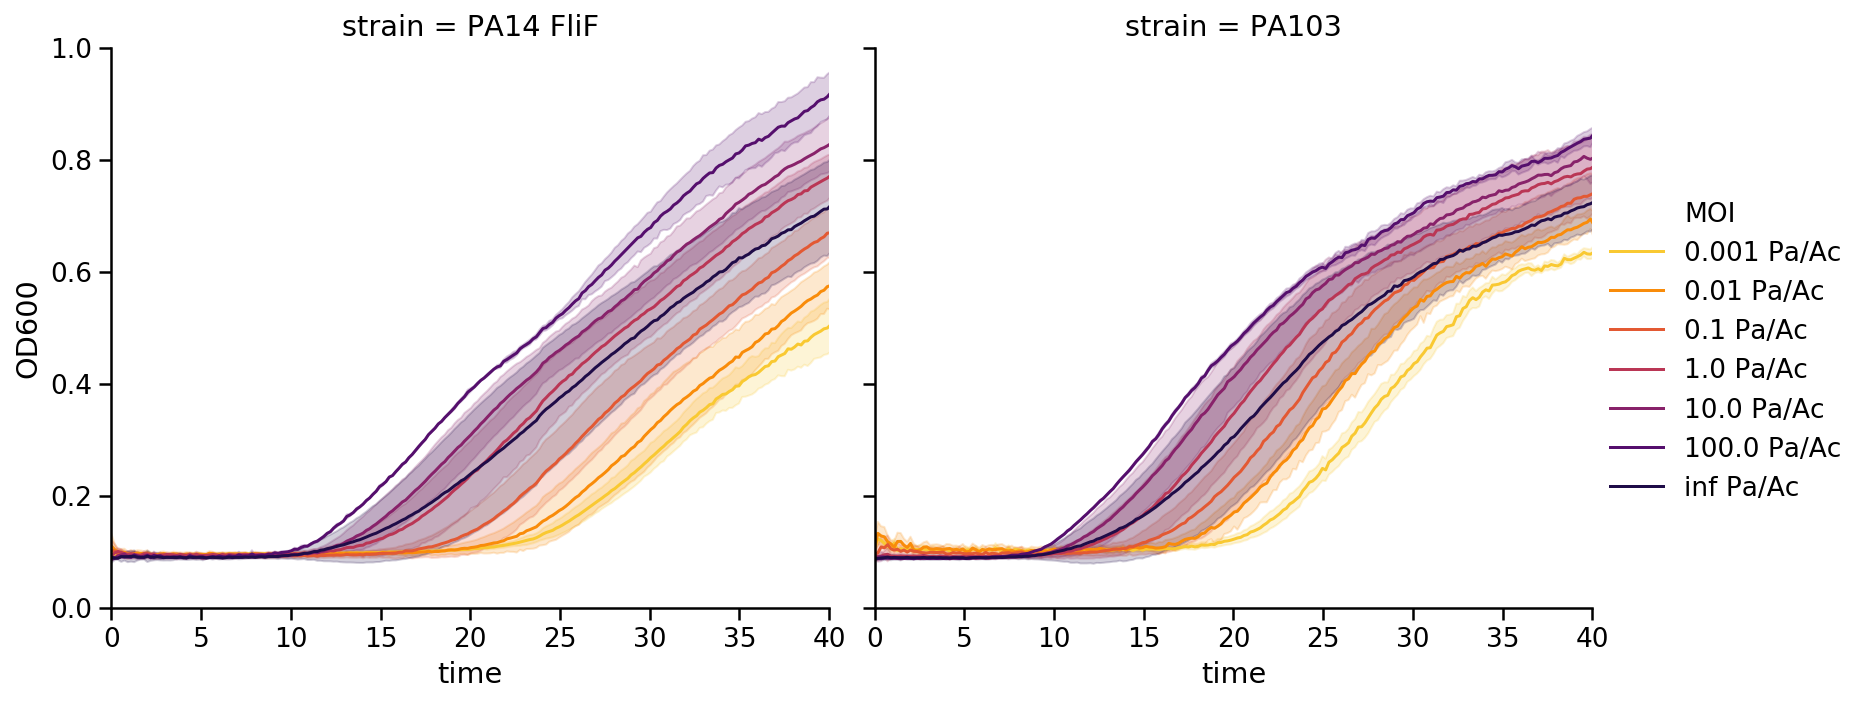

In [53]:
g = sns.relplot(data=data_cat,
                col='strain',
                hue='MOI', 
                x='time',
                y='OD600',
                ci='sd',
                palette='inferno_r',
                
                # increase the aspect ratio to stretch the subplots
                aspect=1.15,
                # set the overall height to increase the size of the subplots
                height=5, 
                kind='line')

# set the limits of the x- and y-axes
plt.xlim([0,40]);
plt.ylim([0,1.]);

Show different inocula of _P. aeruginosa_ as different facets, with different inocula of _A. castellanii_ as different-colored traces. 

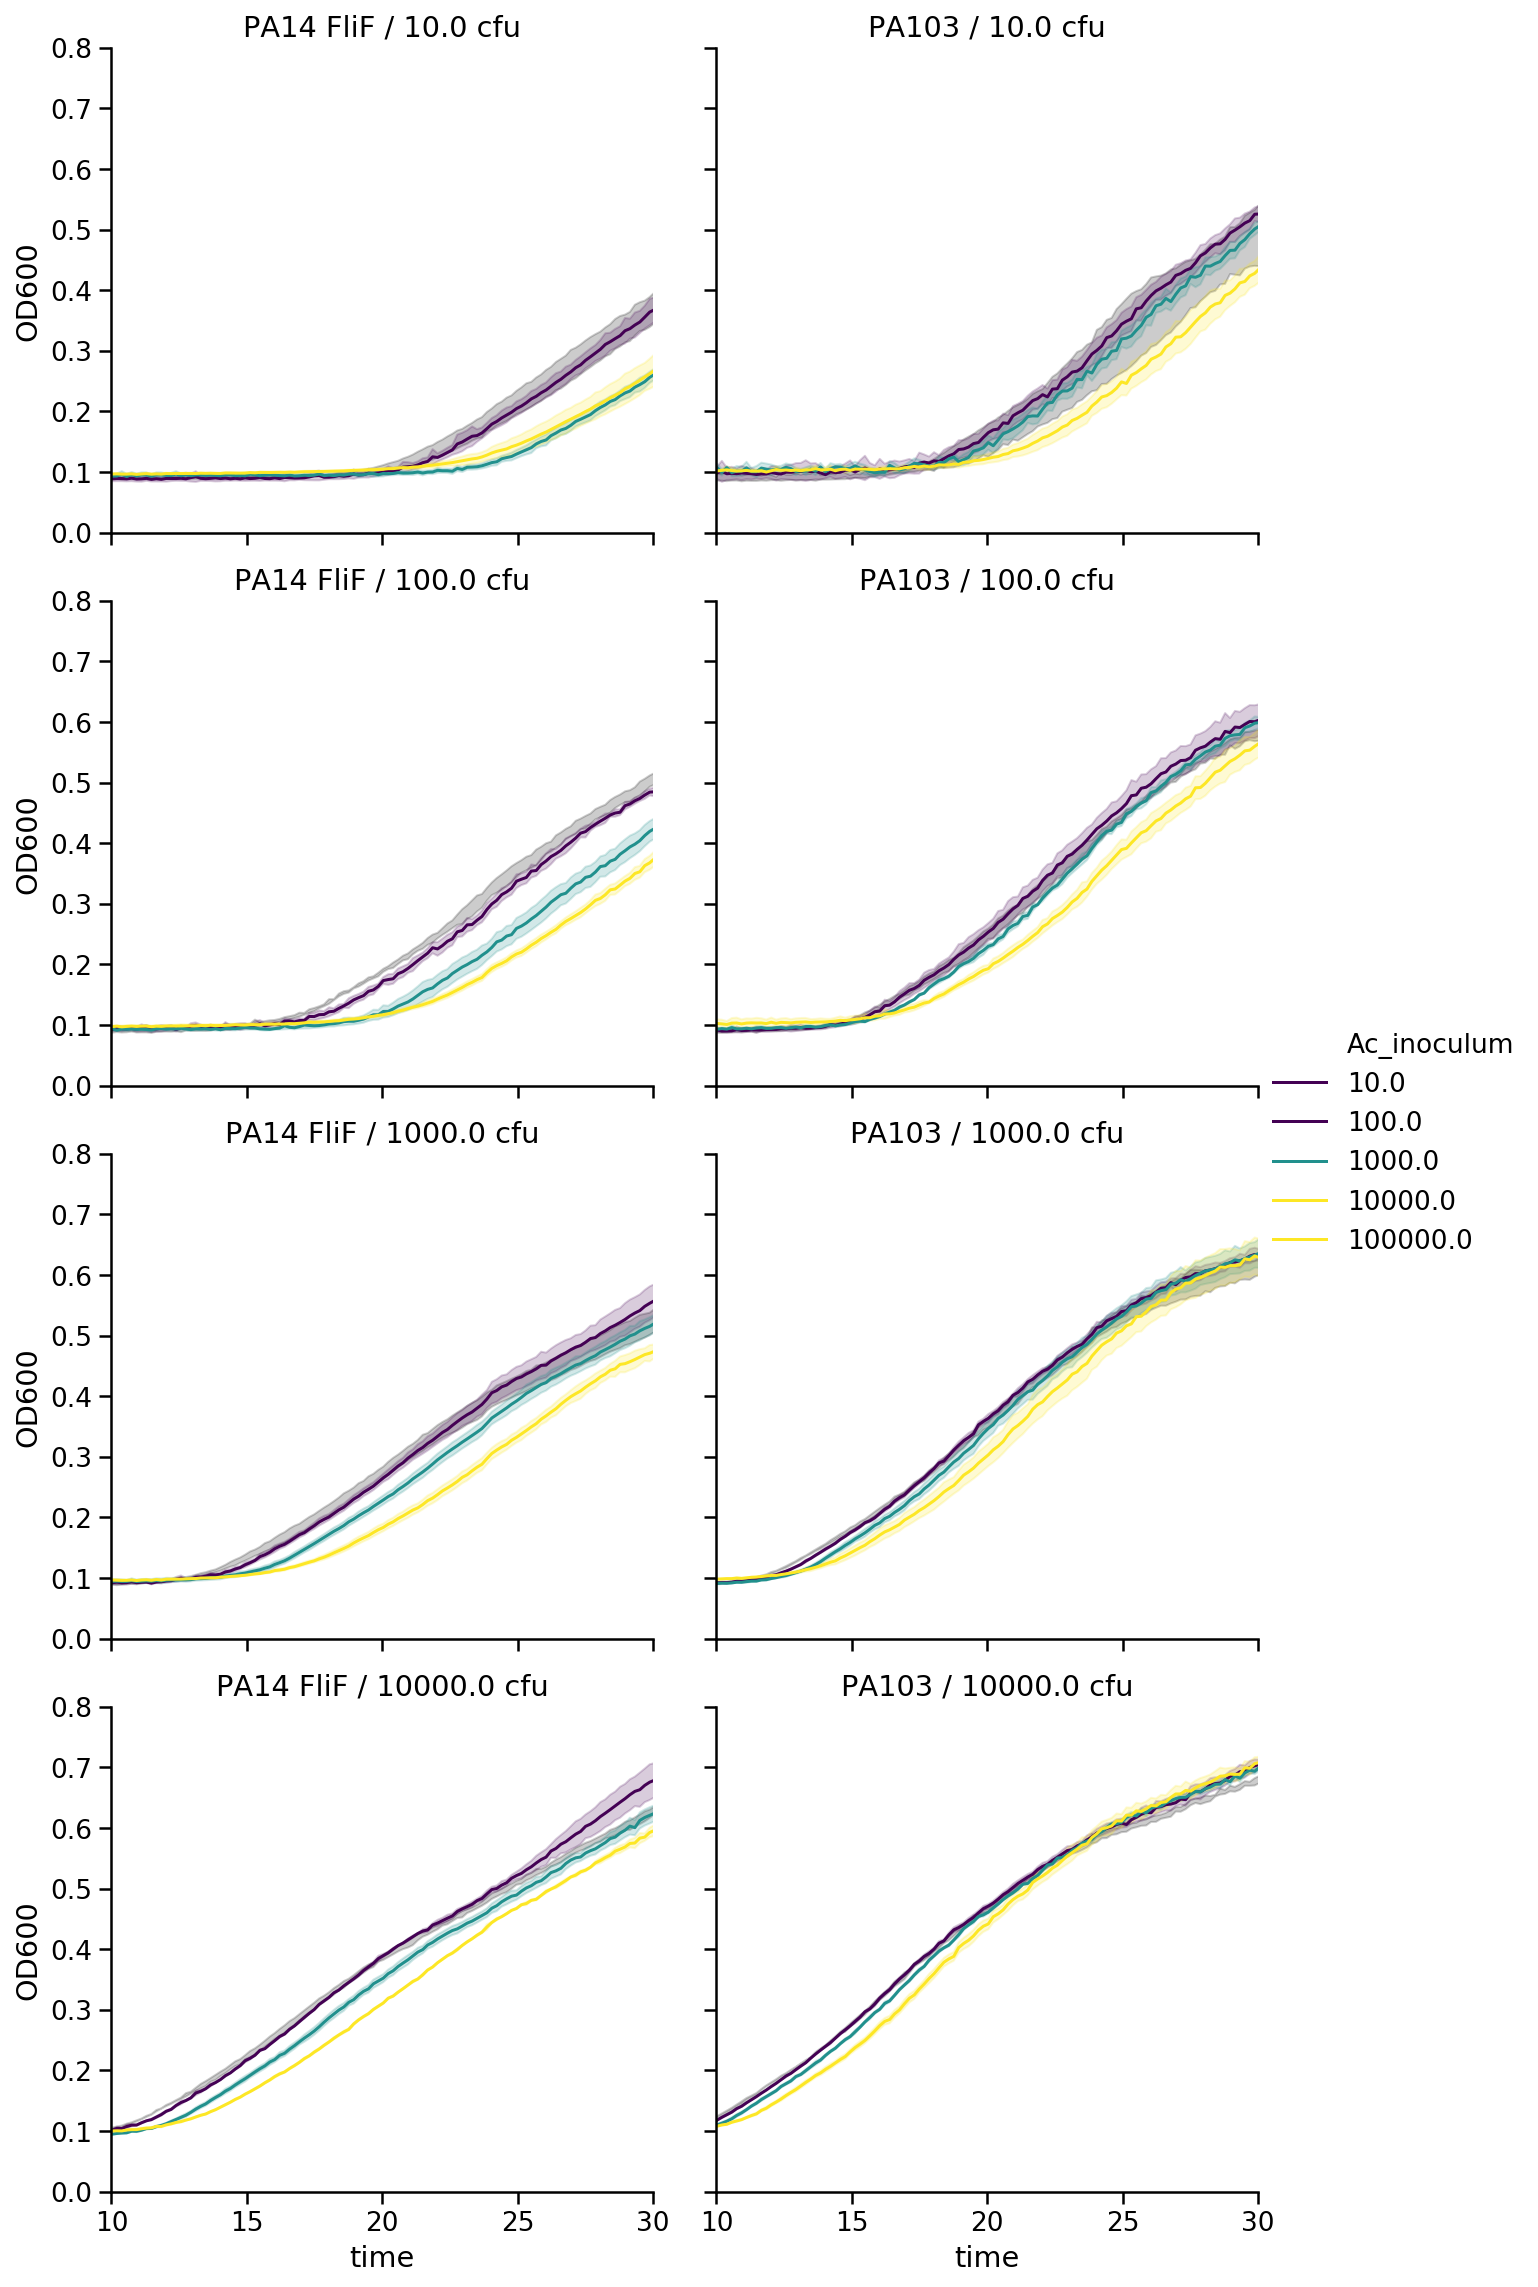

In [54]:
g = sns.relplot(data=data_cat,
                col='strain',
                row='Pa_inoculum',
                hue='Ac_inoculum', 
                hue_norm=LogNorm(),
                
                x='time',
                y='OD600',
                ci='sd',
                palette='viridis',
                
                legend='brief',
                aspect=1.15,
                height=4, 
                kind='line')

# set a title for each subplot
g.set_titles("{col_name} / {row_name} cfu")

# set the limits of the x- and y-axes
plt.xlim([10,30]);
plt.ylim([0,0.8]);

**Exercise**: plot inocula of _P. aeruginosa_ (`'Pa_inoculum'`) as colored-traces and inocula of _A. castellanii_ (`'Ac_inoculum'`) in rows of facets; plot different strains of _P. aeruginosa_ (`'strain'`) in different columns.

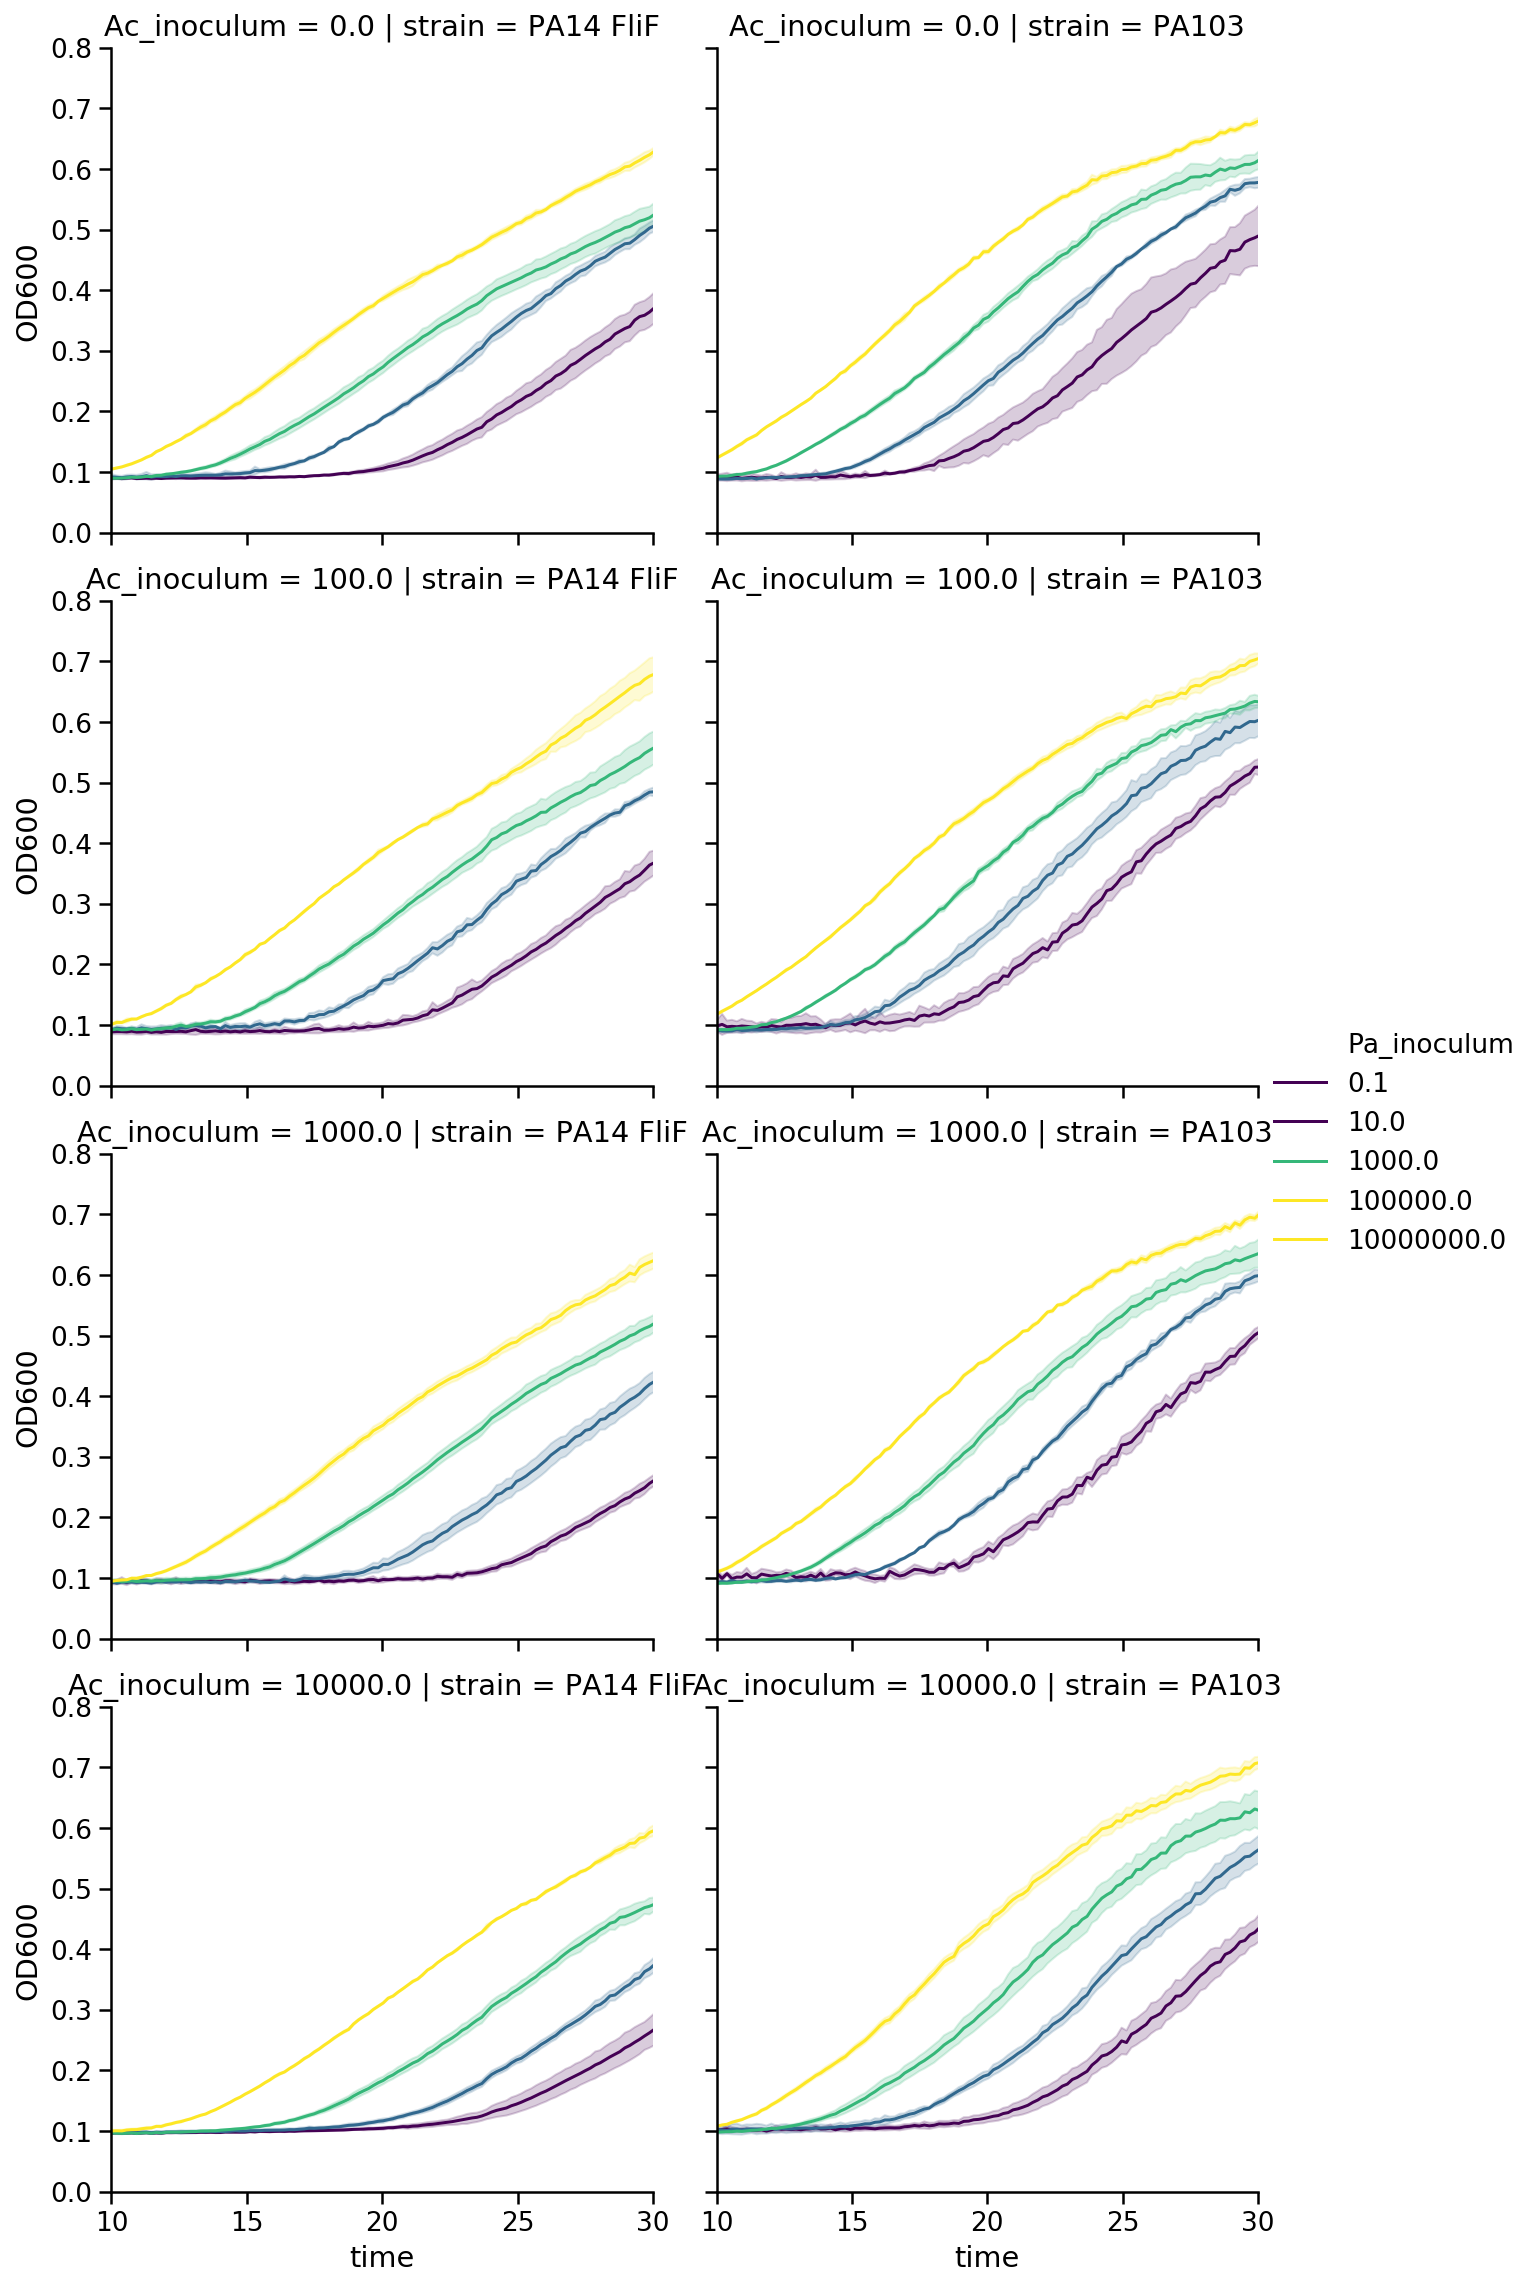

In [55]:
g = sns.relplot(data=data_cat,
                col='strain',
                row='Ac_inoculum',
                hue='Pa_inoculum', 
                hue_norm=LogNorm(),
                
                x='time',
                y='OD600',
                ci='sd',
                palette='viridis',
                
                legend='brief',
                # increase the aspect ratio to stretch the subplots
                aspect=1.15,
                # set the overall height to increase the size of the subplots
                height=4, 
                kind='line')

# set the limits of the x- and y-axes
plt.xlim([10,30]);
plt.ylim([0,0.8]);

#### A peek under the hood: `FacetGrid`

Both `relplot` and `catplot` are based on a Seaborn function called [`FacetGrid`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html). You can recreate the behavior of `relplot` with `kind='line'` using code like this:

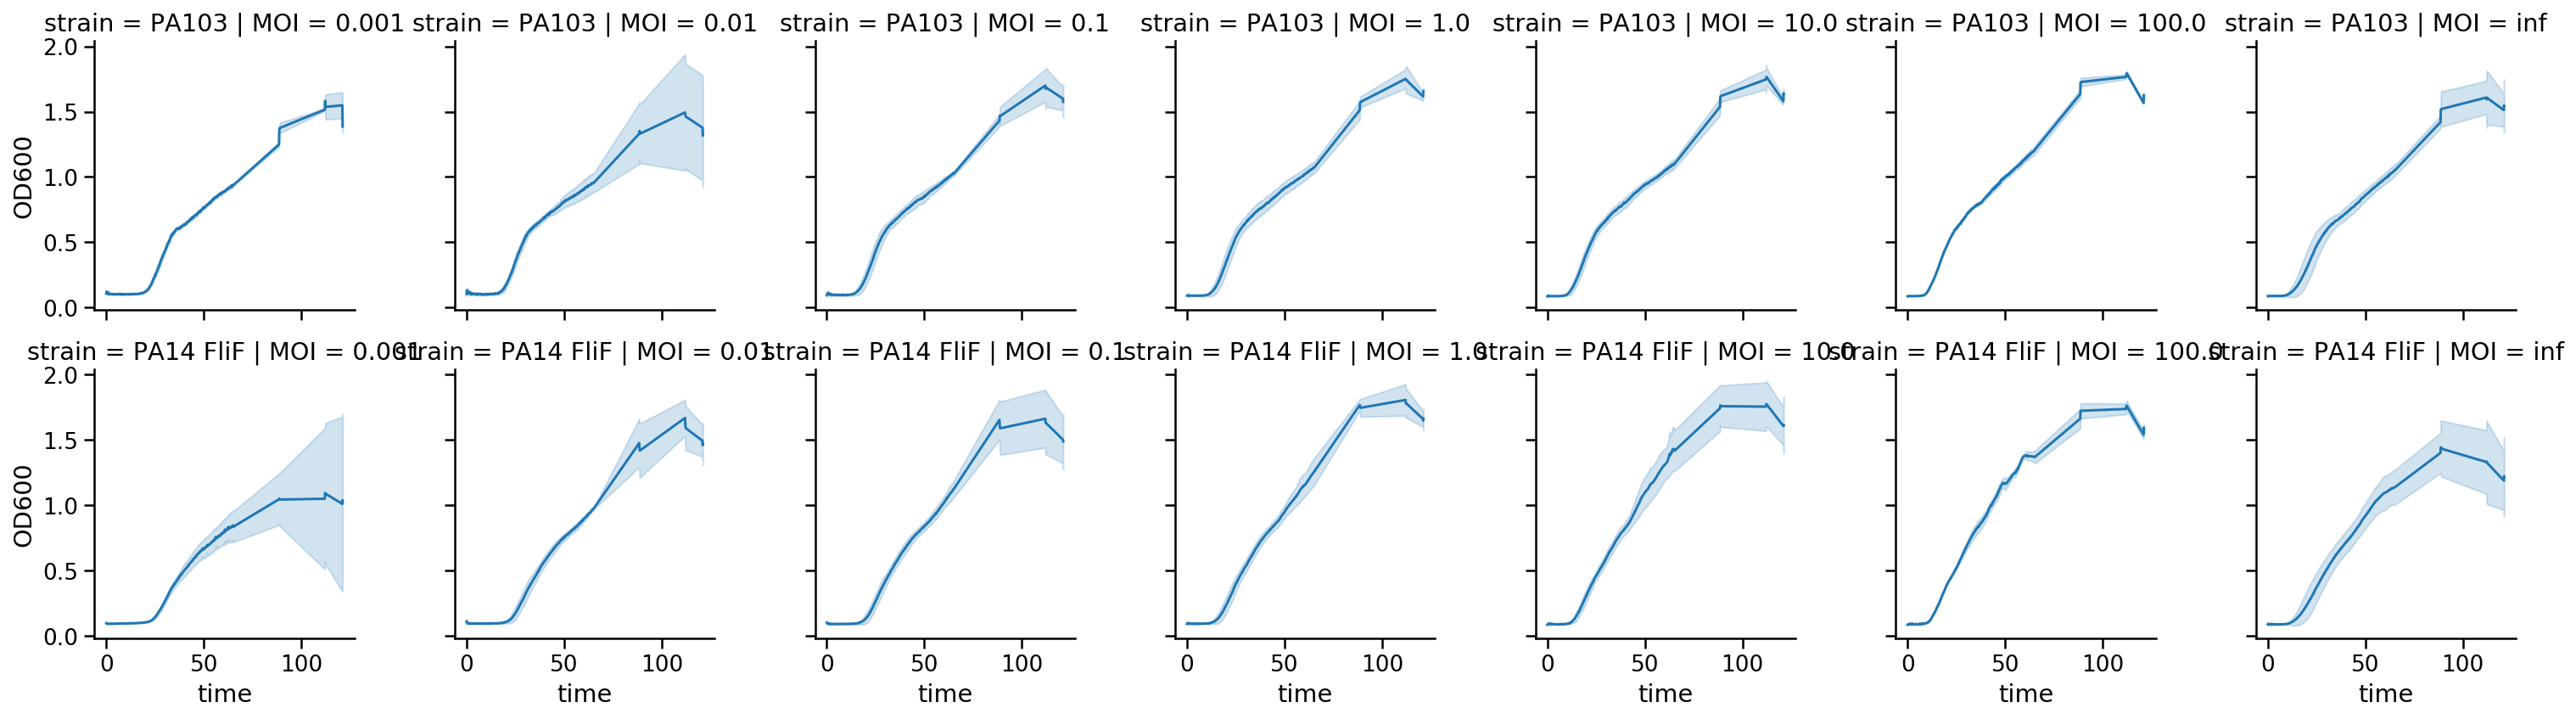

In [56]:
g = sns.FacetGrid(data=data,col='MOI',row='strain')
g.map_dataframe(sns.lineplot,'time','OD600',ci='sd')

Using `FacetGrid` is a little different than using `catplot`, because `FacetGrid` is more general than `catplot`---rather than just categorical plots, `FacetGrid` can actually be used for any type of plot! Because of this, using `FacetGrid` requires two steps:

1. Create the FacetGrid, and specify how to apply variables to `row`s and `col`umns of the grid, as well as what variable(s) to use to determine the `hue`

    ```python
    g = sns.FacetGrid(data=data,col='MOI',row='strain')
    ```

2. Apply (`map`) some plotting function to each position in the grid; specify the variables to pass to this plotting function here---generally the two variables will correspond to `x` and `y`.

    ```python
    g.map_dataframe(sns.lineplot,'time','OD600',ci='sd')
    ```
    
    Notice that you do **not** write `x='time'`, `y='OD600'` like you did for `catplot`. 

One place this can be very useful is for overlaying different types of plots; you can just call `map_dataframe` multiple times for the different styles of plots. For example, let's display a spaghetti plot of different traces on top of a mean and confidence interval:

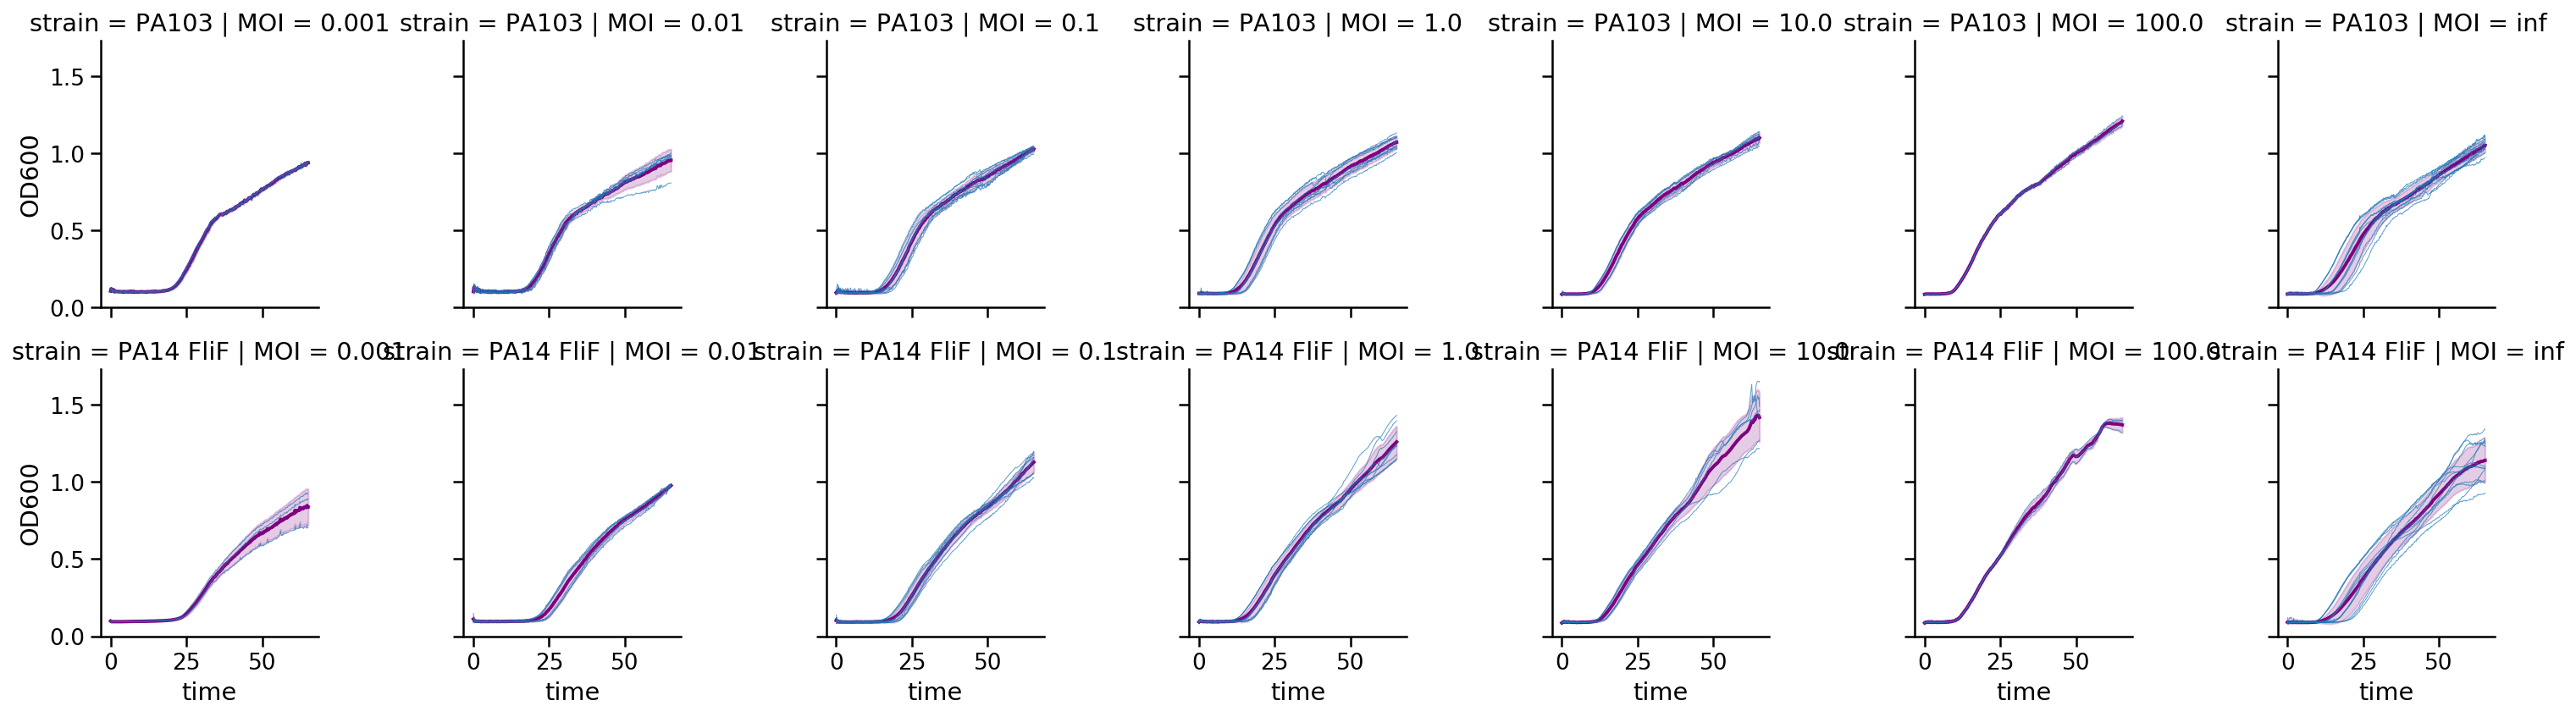

In [57]:
g = sns.FacetGrid(data=data.query('time < 75'),col='MOI',row='strain')
# plot a mean with a confidence interval band
g.map_dataframe(sns.lineplot,'time','OD600',ci='sd',linewidth=2,color='purple')
# show a spaghetti plot with traces of each individual well
g.map_dataframe(sns.lineplot,'time','OD600',estimator=None,units='well',alpha=0.7,linewidth=0.5)

## Case 3: mutants + Tungstate

Goal: this experiment compares mutants of PAO1 grown in the presence or absence of tungstate

Data: single time series.

Data wrangling is very similar to what we've seen before

In [58]:
# load data from Excel file
data = pd.read_excel('./data/2018-03-29_CG007e.xlsx',
              sheet_name=0, header=36, skipfooter=4, index_col=0)

# Extract temperature vs. time as separate variable, then drop (delete)
# it from the main data frame
temps = data.loc['Temp. [°C]',:]
data = data.drop('Temp. [°C]')

# collect data into "tidy" format, with one row per observation, 
# one column for each variable (well, time, OD600)
data.columns = data.columns.rename('time')
data.index = data.index.rename('well')
data = data.reset_index()
data = data.melt(id_vars=['well'],value_name='OD600')

# build platemap with relevant metadata
platemap = plates.spec96to384(plates.prog2spec({
    "A:A,H:H,1:1,12:12": { "sterile":1 },
    "B2:G11":            { "sterile":0 },
    
    "B2:G3":   { "strain":"PAO1" , "phenotype":"susceptible" },
    "B4:G5":   { "strain":"30"   , "phenotype":"susceptible" },
    "B6:G7":   { "strain":"31"   , "phenotype":"susceptible" },
    "B8:G9":   { "strain":"35"   , "phenotype":"susceptible" },
    
    "2:2,4:4,6:6,8:8,10:10": { "tungstate":0  },
    "3:3,5:5,7:7,9:9,11:11": { "tungstate":10 },
    
    "B:B": { "dilution":2**-0 },
    "C:C": { "dilution":2**-1 },
    "D:D": { "dilution":2**-2 },
    "E:E": { "dilution":2**-3 },
    "F:F": { "dilution":2**-4 },
    "G:G": { "dilution":2**-5 }
}, include_row_column=True))

# join platemap to the raw data
data = pd.merge(data,platemap, how='inner', left_on='well',right_index=True)


# convert time series data from seconds to hours
data['time'] = data['time']/3600.0

# anything not specifically marked as sterile was innoculated
# data = data.fillna(value={'sterile':0})

In [59]:
data.dropna().head()

well      time   OD600 row column sterile strain    phenotype tungstate  \
50     C3         0  0.1173   2      2       0   PAO1  susceptible         0   
434    C3  0.191722  0.1160   2      2       0   PAO1  susceptible         0   
818    C3  0.383417  0.1191   2      2       0   PAO1  susceptible         0   
1202   C3  0.575139  0.1220   2      2       0   PAO1  susceptible         0   
1586   C3  0.766833  0.1196   2      2       0   PAO1  susceptible         0   

     dilution  
50          1  
434         1  
818         1  
1202        1  
1586        1

In [60]:
data.describe()

OD600
count  39552.000000
mean       0.203752
std        0.106334
min        0.097900
25%        0.120600
50%        0.140100
75%        0.339200
max        0.438100

In [61]:
data.describe(exclude=[np.number])

well       time    row  column  sterile strain    phenotype  \
count   39552  39552.000  39552   39552  39552.0  19776        19776   
unique    384    103.000     16      24      2.0      4            1   
top       I23      2.876     15      23      0.0   PAO1  susceptible   
freq      103    384.000   2472    1648  24720.0   4944        19776   

        tungstate     dilution  
count     32960.0  29664.00000  
unique        2.0      6.00000  
top          10.0      0.03125  
freq      16480.0   4944.00000

### Case 3: Plotting

I mostly included this to highlight an alternative plotting library, called [plotnine](http://plotnine.readthedocs.io/en/stable/index.html). Plotnine is a port of [`ggplot2`](http://ggplot2.tidyverse.org), a very popular package for R based on the ["Grammar of Graphics"](https://www.springer.com/us/book/9780387245447). This concept is very appealing, because it's much more flexible than even what we've been able to do with Seaborn.

The basic idea is that a graphic is composed of **layers** stacked to create a complex plot. Each layer can map several "aesthetics" (like `x`, `y`, and `hue` as we've seen, but also `size`, `stroke`, `marker`, etc. depending on the type of layer) to different variables in the data. This allows, in principle, an amazing variety of plots to be created with remarkable simplicity. See examples [here](http://r4ds.had.co.nz/data-visualisation.html) and [here](http://r4ds.had.co.nz/graphics-for-communication.html). 

Pythonistas have long waited for a worthy replacement for `ggplot2`, and `plotnine` has only appeared relatively recently. I'll admit, I haven't quite gotten the hang of it—the documentation is somewhat sparse compared to Seaborn, assuming that most people using it will know how to use `ggplot2`. It seems a bit rough around the edges in a few places (it causes pandas to shout tons of warnings), but it will be interesting to watch.

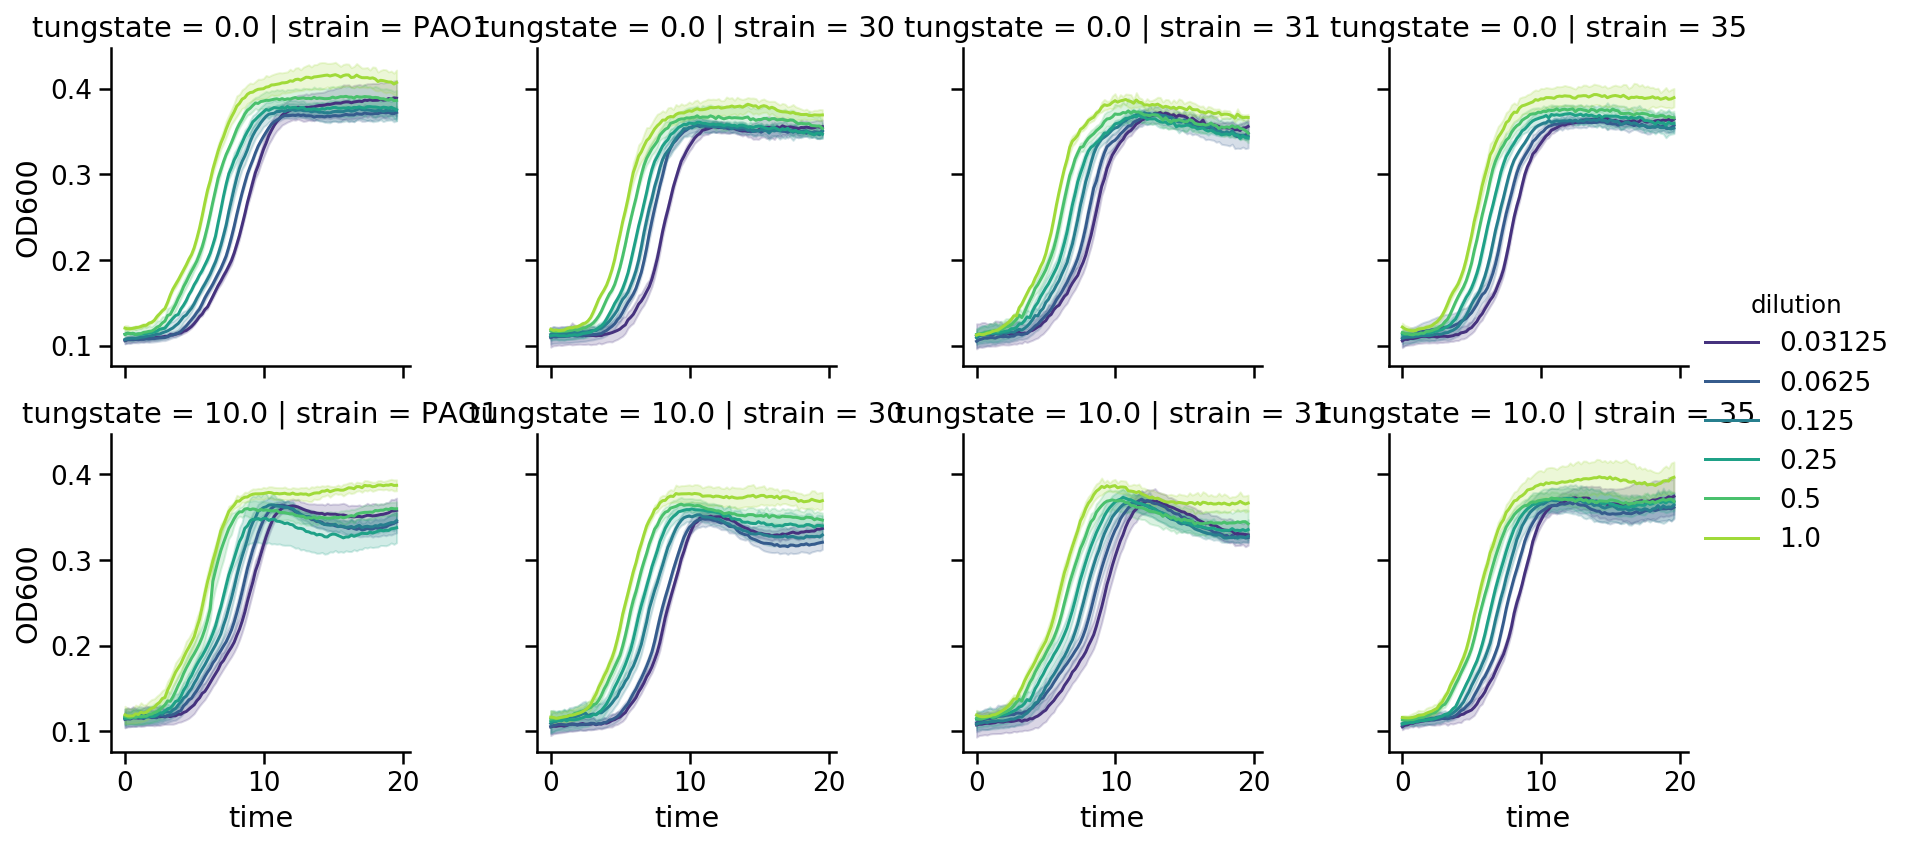

In [62]:
# Seaborn plot to compare
g = sns.FacetGrid(data=data.query('sterile == 0'),
                  col='strain',row='tungstate',hue='dilution',
                  palette='viridis',legend_out=True)
g.map_dataframe(sns.lineplot,'time','OD600',legend='full',ci='sd')
g.add_legend()

In [63]:
from plotnine import *
import warnings
warnings.filterwarnings(action='ignore')

In [64]:
# numeric data needs to be cast as such, or plotnine will complain and treat it like categorical data
data = data.apply(pd.to_numeric,errors='ignore')

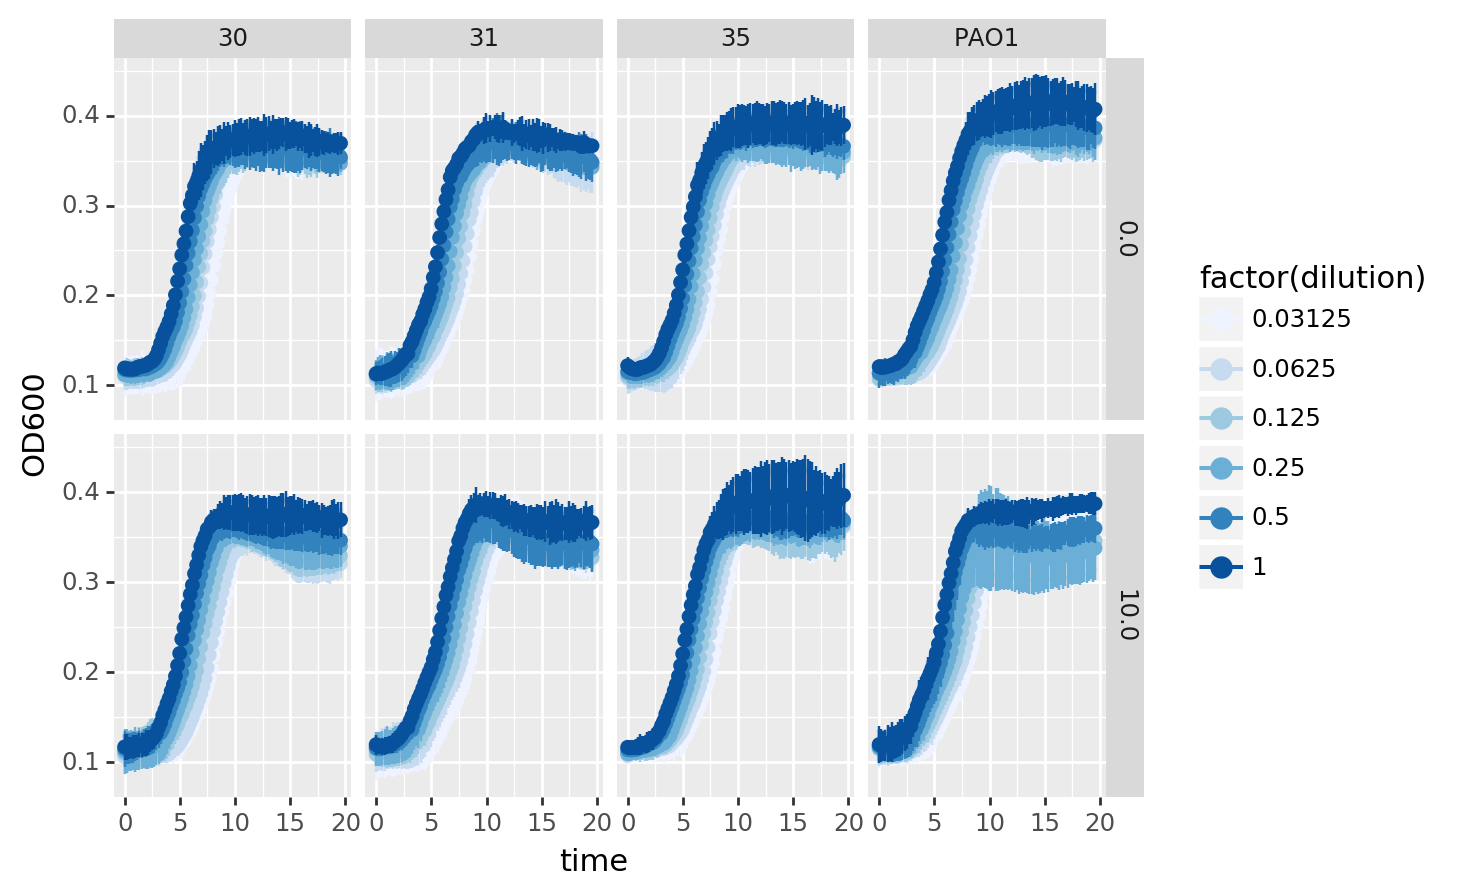

<ggplot: (288371064)>

In [65]:
(ggplot(data.query('sterile == 0').dropna(), aes('time', 'OD600',color='factor(dilution)'))
 + geom_point(alpha=0.1,size=0.1)
 + scale_x_continuous(breaks=range(0,25,5))
 + scale_color_brewer()
 + stat_summary(fun_data='mean_sdl')
 + facet_grid('tungstate ~ strain'))

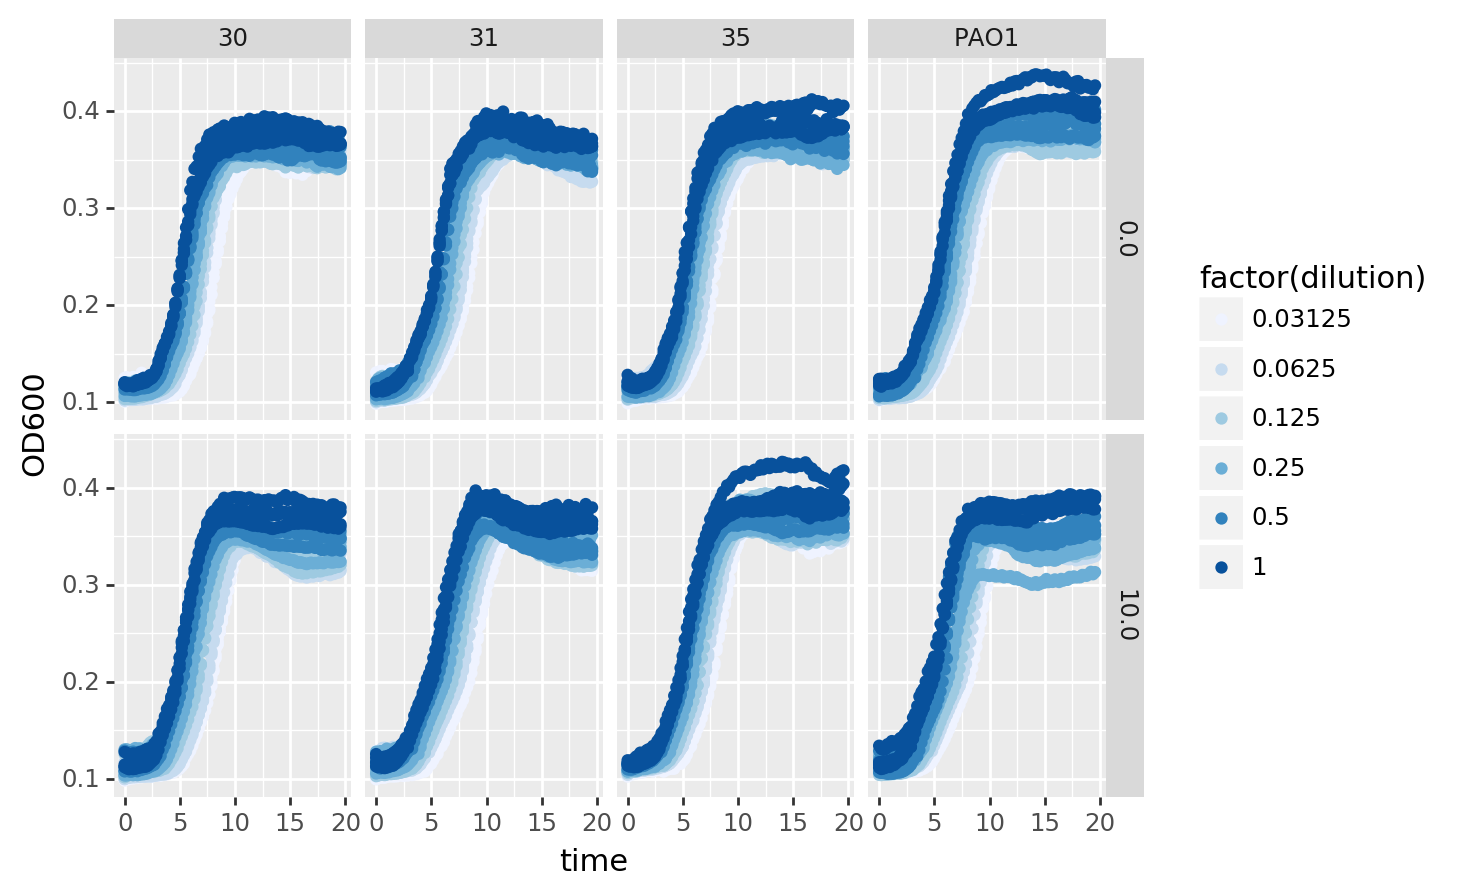

<ggplot: (299646426)>

In [66]:
(ggplot(data.query('sterile == 0').dropna(), aes('time', 'OD600',color='factor(dilution)'))
 + geom_point()
 + scale_x_continuous(breaks=range(0,25,5))
 + scale_color_brewer()
 + facet_grid('tungstate ~ strain'))